In [391]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore")

In [392]:
import re

import pandas as pd
import numpy as np

import constants as cons

from PIL import Image
from IPython.display import display

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import plotly.graph_objs as go
import plotly.offline as py
import seaborn as sns

from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from lofo import LOFOImportance, Dataset, plot_importance

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [393]:
%matplotlib inline
sns.set(style='white', context='notebook', palette='deep') 

import matplotlib.style as style
style.use('fivethirtyeight')
import time

In [394]:
df = pd.read_csv(cons.file_path, index_col=0)
df_raw = df.copy()

In [395]:
###################################### EXPLORE ######################################

In [396]:
df.head(1)

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,,10009,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00


In [397]:
df.shape

(84548, 21)

In [398]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84548 entries, 4 to 8413
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   BOROUGH                         84548 non-null  int64 
 1   NEIGHBORHOOD                    84548 non-null  object
 2   BUILDING CLASS CATEGORY         84548 non-null  object
 3   TAX CLASS AT PRESENT            84548 non-null  object
 4   BLOCK                           84548 non-null  int64 
 5   LOT                             84548 non-null  int64 
 6   EASE-MENT                       84548 non-null  object
 7   BUILDING CLASS AT PRESENT       84548 non-null  object
 8   ADDRESS                         84548 non-null  object
 9   APARTMENT NUMBER                84548 non-null  object
 10  ZIP CODE                        84548 non-null  int64 
 11  RESIDENTIAL UNITS               84548 non-null  int64 
 12  COMMERCIAL UNITS                84548 non-null  int6

<a id='3'></a><center> <h2 style="background-color:green; color:white" ><br>1. DATA CLEANING  <br></h2>

In [399]:
df['BOROUGH'] = df['BOROUGH'].map(cons.borough_encoding)

df['SALE PRICE'] = df['SALE PRICE'].replace({' -  ':'0'})
df['SALE PRICE'] = df['SALE PRICE'].astype(float)

#df['GROSS SQUARE FEET'] = df['GROSS SQUARE FEET'].map(lambda x: year_built(x))
df['GROSS SQUARE FEET'] = df['GROSS SQUARE FEET'].replace({' -  ':'0'})
df['GROSS SQUARE FEET'] = df['GROSS SQUARE FEET'].astype(int)

df['MONTH SOLD'] = df['SALE DATE'].map(lambda x: x[5:7])
df['MONTH SOLD'] = df['MONTH SOLD'].map(lambda x: int(x))
df['SALE DATE'] = pd.to_datetime(df['SALE DATE'])
df['YEAR SOLD']= df['SALE DATE'].dt.year
df['BUILDING AGE'] = 2017 - df['YEAR BUILT']

df = df.replace(to_replace=r'^\s*[-]\s*', value=np.nan, regex=True)
map_dict={'-':np.nan,' ':np.nan}
df.replace(map_dict,inplace = True)


for col in cons.numeric_columns: 
    df[col] = pd.to_numeric(df[col], errors='coerce')

for col in cons.categorical_columns: 
    df[col] = df[col].astype(object)

df.drop(["EASE-MENT", "ADDRESS","APARTMENT NUMBER"], axis=1, inplace=True) # Completely empty columns.
df.drop(["YEAR BUILT", "LOT","ZIP CODE", "SALE DATE", "BLOCK"], axis=1, inplace=True) # Unnecessary columns.

In [400]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BUILDING CLASS AT PRESENT,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,MONTH SOLD,YEAR SOLD,BUILDING AGE
4,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,C2,5,0,5,1633.000,6440,2,C2,6625000.000,7,2017,117
5,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,C7,28,3,31,4616.000,18690,2,C7,0.000,12,2016,117
6,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,C7,16,1,17,2212.000,7803,2,C7,0.000,12,2016,117
7,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,C4,10,0,10,2272.000,6794,2,C4,3936272.000,9,2016,104
8,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,C2,6,0,6,2369.000,4615,2,C2,8000000.000,11,2016,117


<a id='3'></a><center> <h2 style="background-color:green; color:white" ><br>2.EXPLORATORY DATA ANALYSIS  <br></h2>

<Axes: >

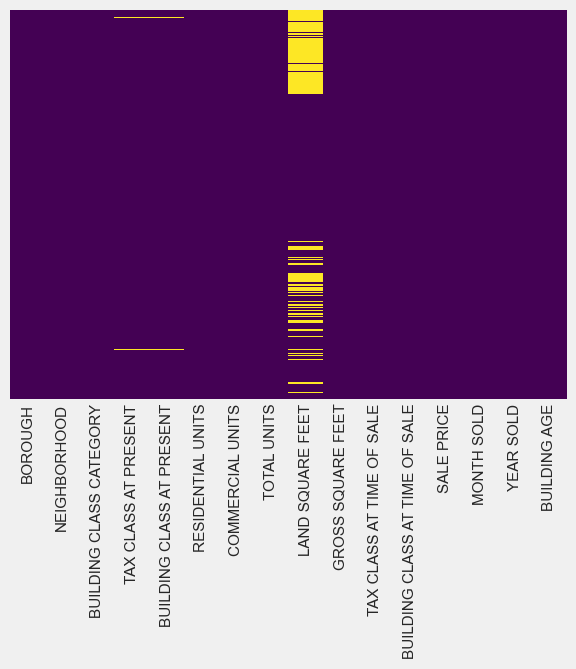

In [401]:
sns.heatmap(
    df.isnull(), 
    yticklabels=False, 
    cbar=False, 
    cmap='viridis'
)

<img src="data/Boroughs_New_York.png" alt="Image caption" width="500" height="200">

<img src="data/Boroughs_New_York_City_Map.png" alt="Image caption" width="400" height="300">

Text(0.5, 1.0, 'Sales per Borough')

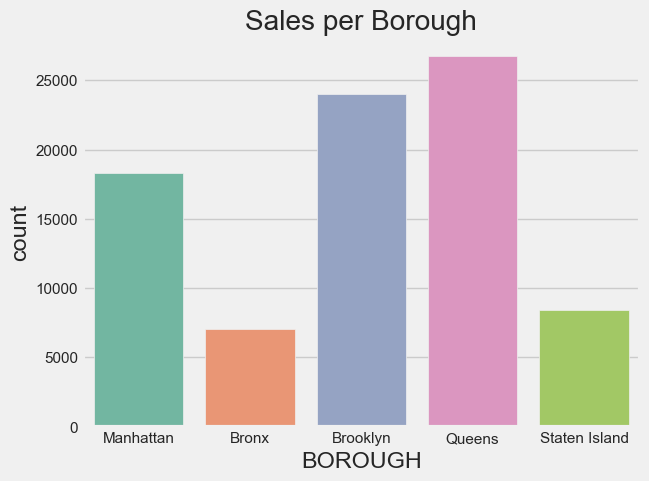

In [402]:
sns.countplot(x='BOROUGH', data=df, palette='Set2')
plt.title('Sales per Borough')

# Maximum properties are sold in Queens! followed by Staten Island!

Text(0.5, 1.0, 'Sales per Borough Residential')

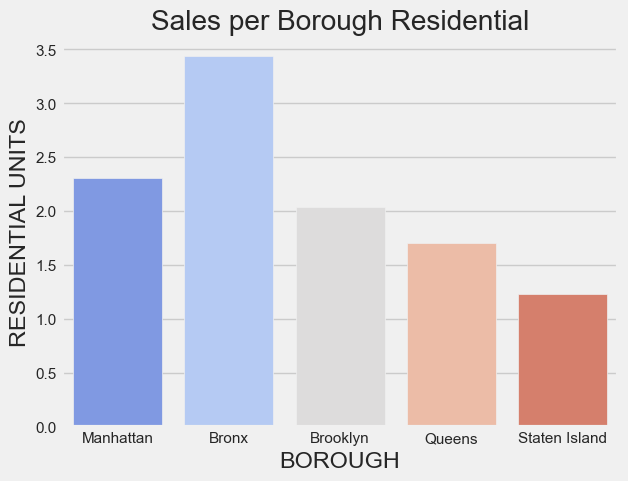

In [403]:
sns.barplot(y='RESIDENTIAL UNITS', x='BOROUGH',data=df, palette='coolwarm', ci=None)
plt.title('Sales per Borough Residential')

# Residential Units are mainly sold in ...

Text(0.5, 1.0, 'Sales per Borough Commercial')

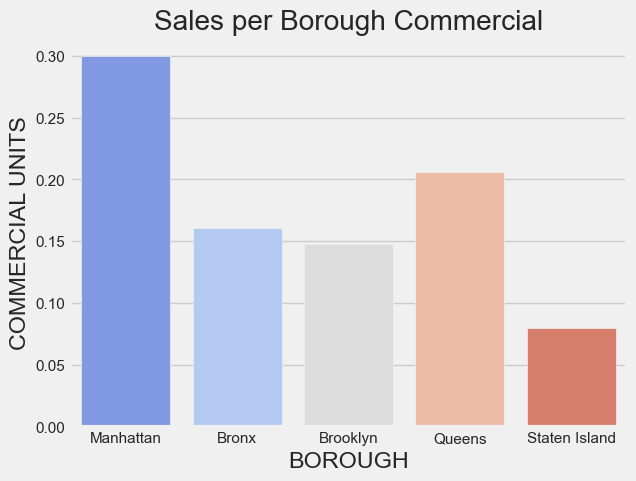

In [404]:
sns.barplot(y='COMMERCIAL UNITS', x='BOROUGH',data=df, palette='coolwarm', ci=None)
plt.title('Sales per Borough Commercial')

Text(0.5, 1.0, 'Sales Rate from 2016-2017')

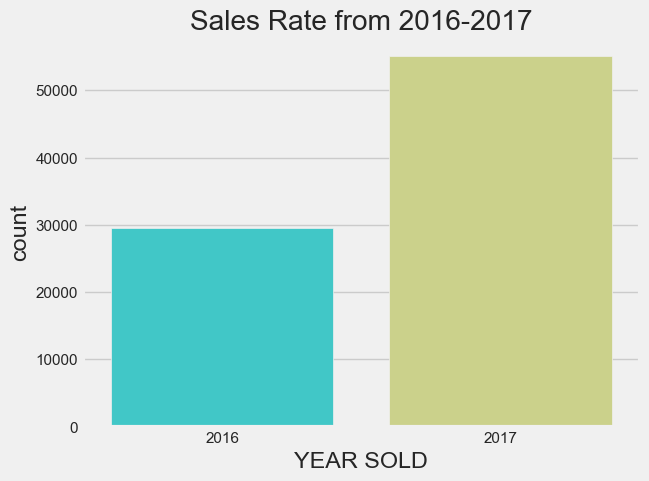

In [405]:
sns.countplot(x='YEAR SOLD', data=df, palette='rainbow')
plt.title('Sales Rate from 2016-2017')

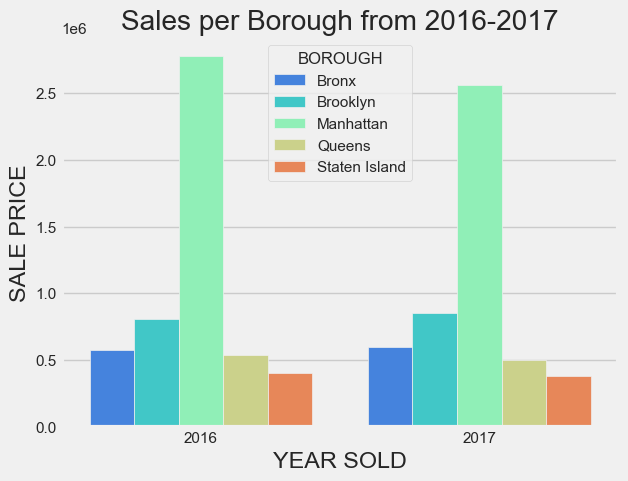

In [406]:
summary_data = df.groupby(['YEAR SOLD', 'BOROUGH'])['SALE PRICE'].mean().reset_index()

# Barplot'u oluşturun
sns.barplot(
    x='YEAR SOLD', 
    y='SALE PRICE', 
    hue='BOROUGH', 
    data=summary_data, 
    palette='rainbow', 
    ci=None
)
plt.title('Sales per Borough from 2016-2017')
plt.show()

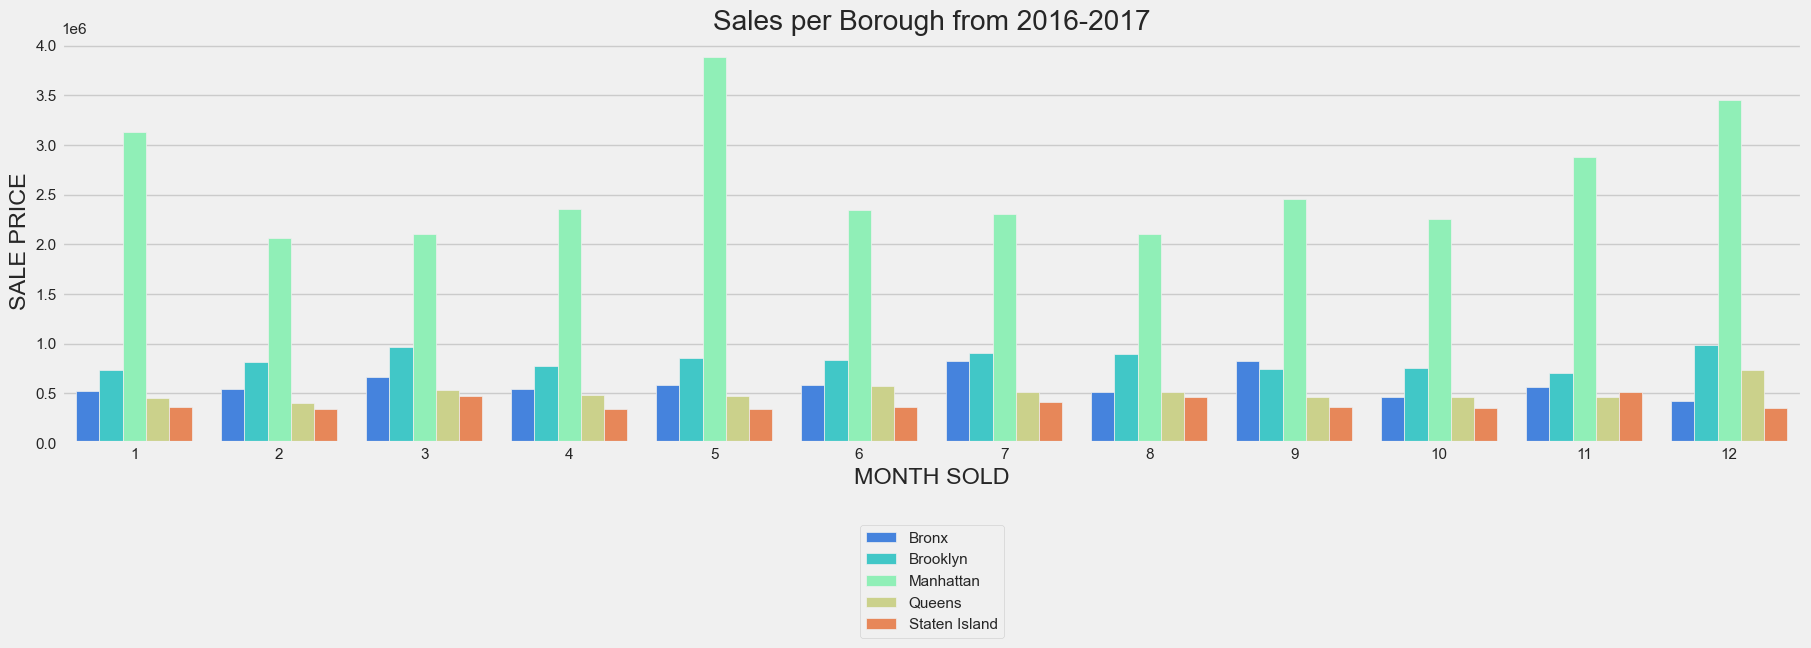

In [407]:
summary_data = df.groupby(['MONTH SOLD', 'BOROUGH'])['SALE PRICE'].mean().reset_index()

plt.figure(figsize=(20,5))
sns.barplot(
    x='MONTH SOLD', 
    y='SALE PRICE', 
    hue='BOROUGH', 
    data=summary_data, 
    palette='rainbow', 
    ci=None
)
plt.title('Sales per Borough from 2016-2017')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5))
plt.show()

'\nIt is noticed that though the number of sales increased from the year 2016 to 2017, \nthe sales prices per Borough(location) remained in the same ranges\nAlso, the property prices are much higher at Manhattan than at any other location.\nAs per months, property sales for 2017 took place from January till August, \nand for 2016 from September till December.'

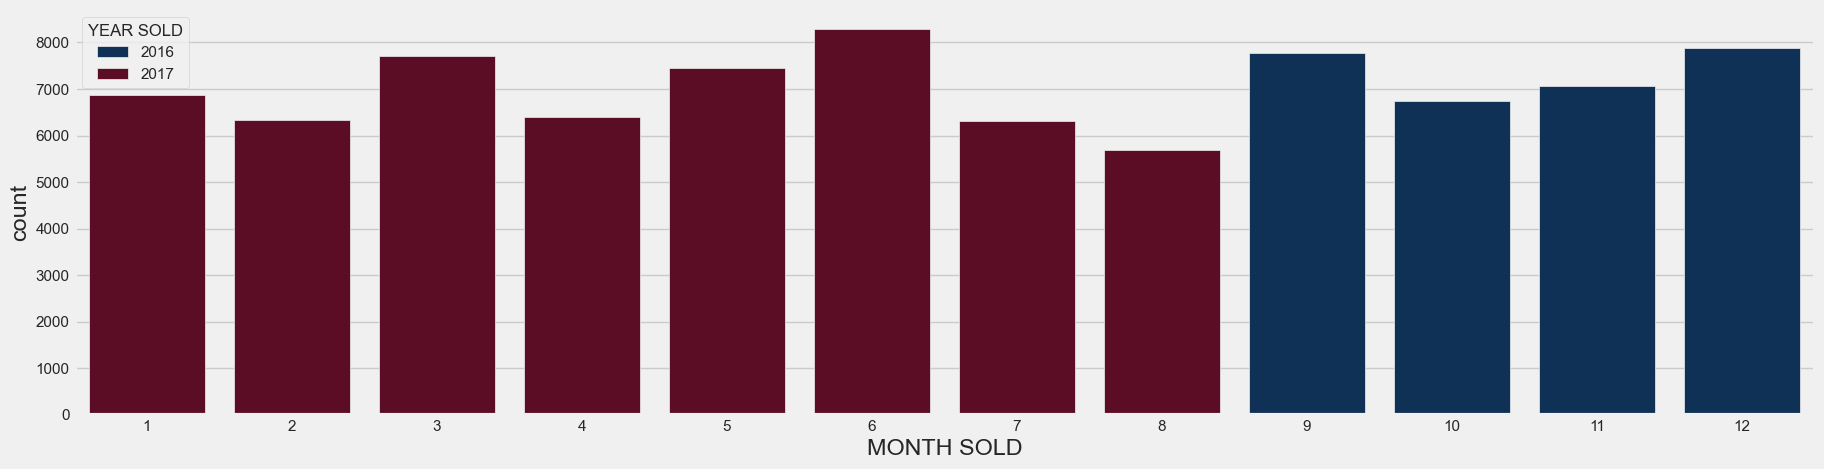

In [408]:
plt.figure(figsize=(20,5))
sns.countplot(x='MONTH SOLD', hue='YEAR SOLD', data=df, palette='RdBu_r')

"""
It is noticed that though the number of sales increased from the year 2016 to 2017, 
the sales prices per Borough(location) remained in the same ranges
Also, the property prices are much higher at Manhattan than at any other location.
As per months, property sales for 2017 took place from January till August, 
and for 2016 from September till December."""

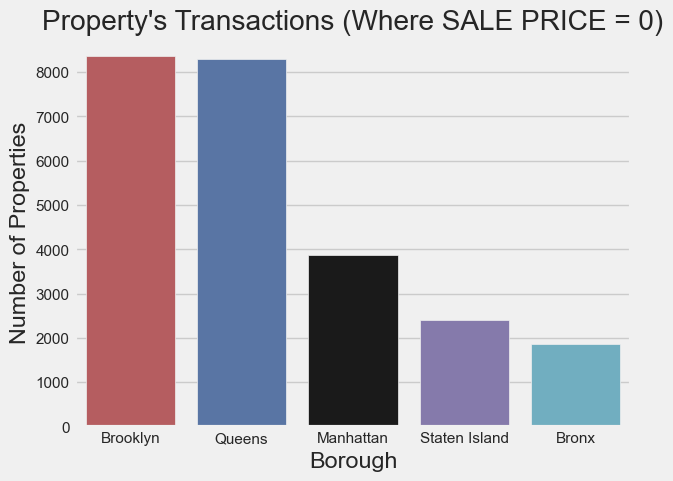

In [409]:
df_filtered = df[df['SALE PRICE'] == 0]

# Create the bar plot with Seaborn
sns.countplot(
    x="BOROUGH",
    data=df_filtered,
    order=df_filtered['BOROUGH'].value_counts().index,  # Sort by value counts
    palette=['r', 'b', 'k', 'm', 'c']  # Set colors
)

# Customize the plot
plt.title("Property's Transactions (Where SALE PRICE = 0)")
plt.xlabel("Borough")
plt.ylabel("Number of Properties")
plt.show()

Since 0 sales means that it's a property transaction so this graph shows the amount of property transactions in each borough.

Text(0.5, 1.0, 'average sales price per propertys usage of buildings')

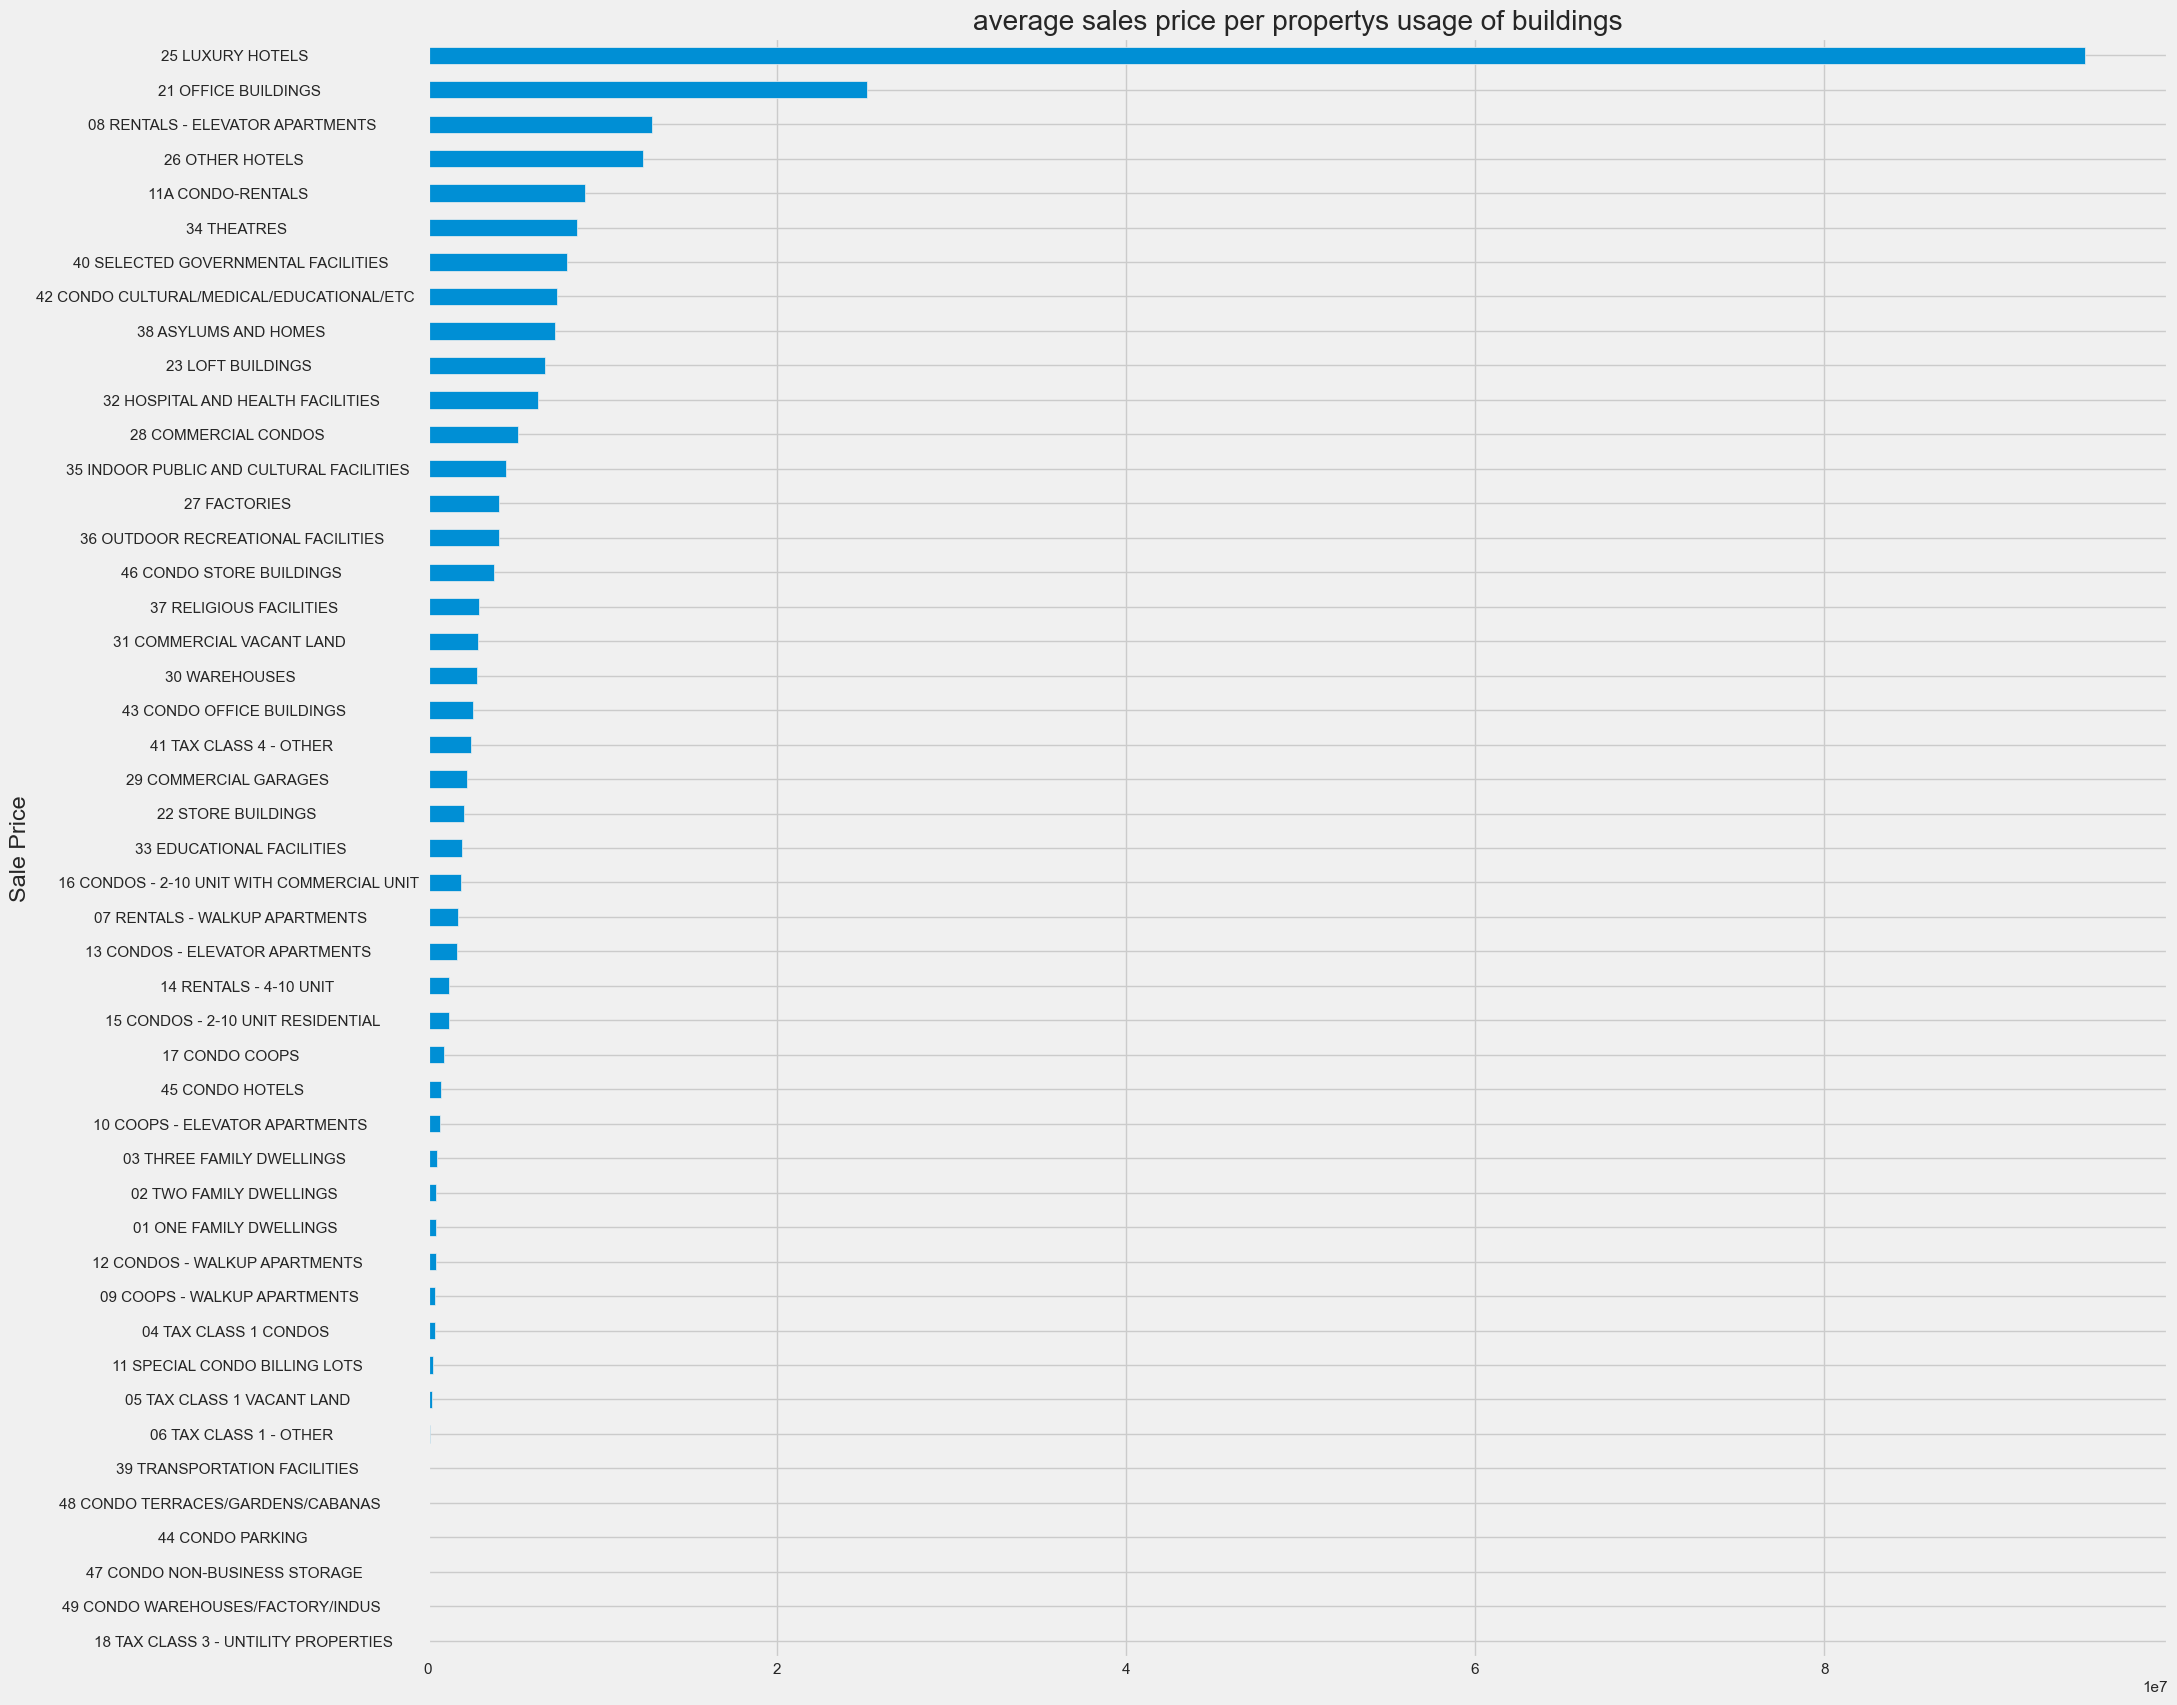

In [410]:
plt.figure(figsize=(20,20))

df['SALE PRICE'].groupby(df['BUILDING CLASS CATEGORY']).mean().sort_values().plot.barh()
plt.ylabel("Sale Price")

plt.title('average sales price per propertys usage of buildings')

Seems to Luxury hotels and office buildings is represents the largest average price category in sales and Untility properties, Warehouses/Factory/Indus are the lowest average price building category in sales.

Text(0.5, 0, 'Sale Price')

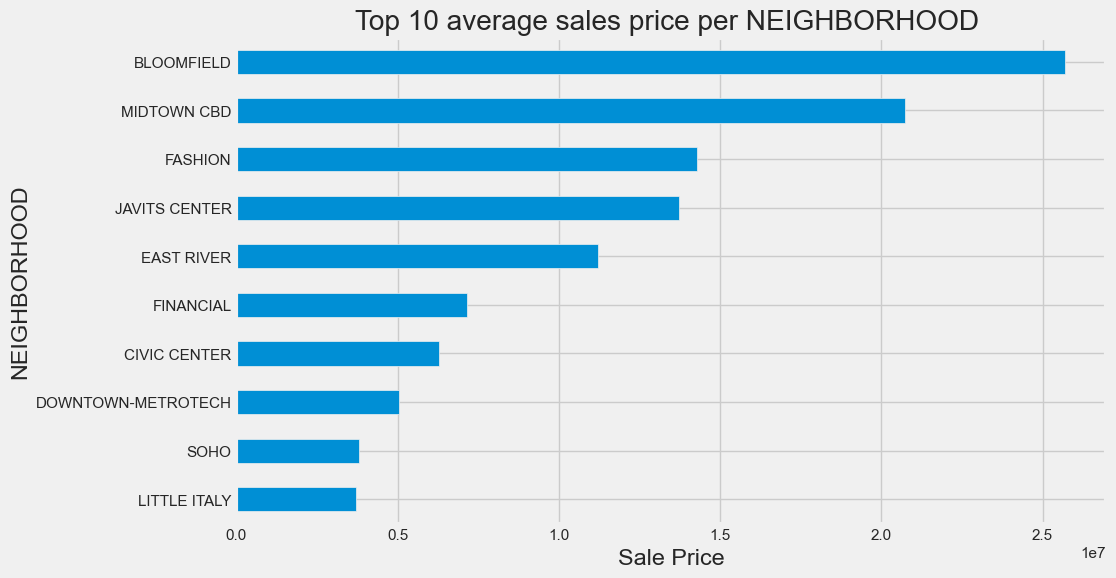

In [411]:
plt.figure(figsize=(10,6))
df['SALE PRICE'].groupby(df['NEIGHBORHOOD']).mean().sort_values()[244:254].plot.barh()
plt.title('Top 10 average sales price per NEIGHBORHOOD ')
plt.xlabel("Sale Price")

BloomField and Midtown CBD have the largest average sales between all neighborhood.

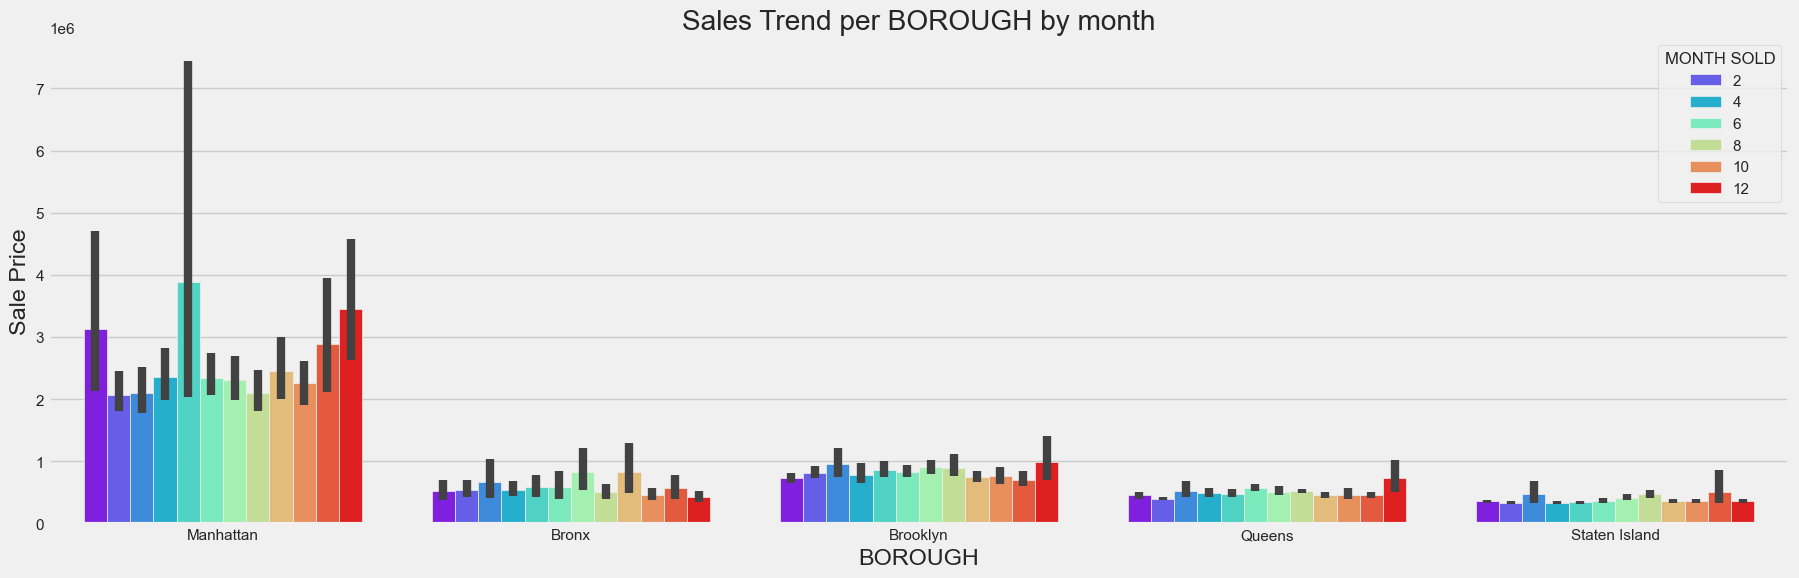

In [412]:
indexed_df = df.reset_index(drop=True)

plt.figure(figsize=(20,6))
sns.barplot(x='BOROUGH', y='SALE PRICE', hue='MONTH SOLD', data=indexed_df, palette='rainbow')
plt.title('Sales Trend per BOROUGH by month')
plt.ylabel('Sale Price')
plt.show()

In [413]:
#m = df.select_dtypes(np.number)
#df[m.columns]= m.round().astype('Int64')
pd.options.display.float_format = '{:,.0f}'.format
# Filter DataFrame
df2 = df[(df['SALE PRICE'] > 100000) & (df['SALE PRICE'] < 5000000)]
df2.rename(columns = {"SALE PRICE":"sale_price"},inplace = True)

boroughs = ['Manhattan', 'Bronx', 'Brooklyn', 'Queens', 'Staten Island']
colors = ['rgb(12, 12, 140)', 'rgb(8,81,156)', 'rgb(12, 12, 140)', 'rgb(12, 128, 128)', 'rgb(12, 12, 140)']

traces = []
for borough, color in zip(boroughs, colors):
    trace = go.Box(
        y=df2[df2.BOROUGH == borough].sale_price,
        name=borough,
        marker=dict(color=color)
    )
    traces.append(trace)

layout = go.Layout(
    title='Housing Prices by Boroughs',
    xaxis=dict(title='Borough'),
    yaxis=dict(title='Sale Price'),
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)'
)

fig = go.Figure(data=traces, layout=layout)
py.iplot(fig)

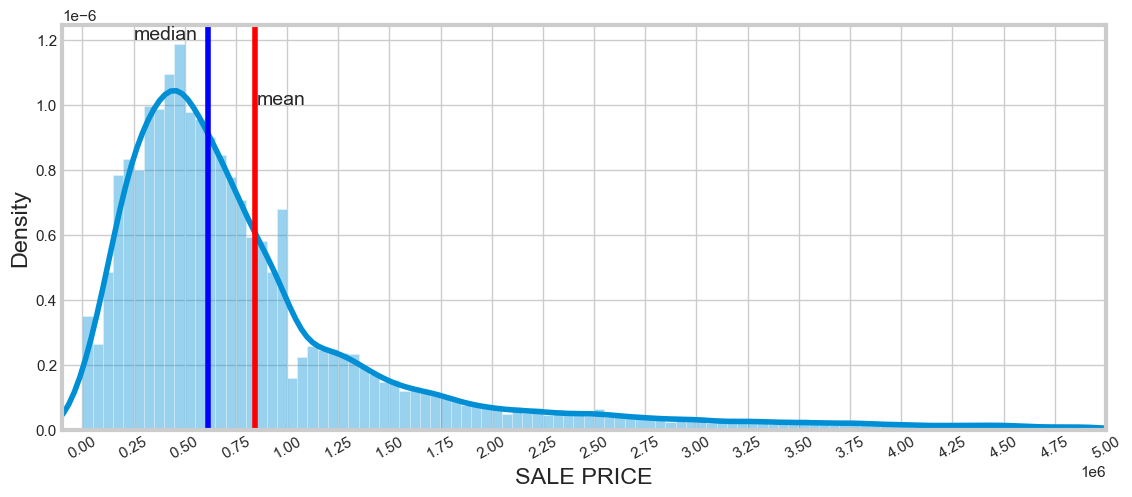

In [414]:
sns.set_style("whitegrid")
plt.figure(figsize=(12,5))
plotd = sns.distplot(df[(df['SALE PRICE']>100) & (df['SALE PRICE'] < 5000000)]['SALE PRICE'], kde=True, bins=100)

tick_spacing=250000
plotd.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
plotd.set_xlim([-100000, 5000000])
plt.xticks(rotation=30)
plt.axvline(df[(df['SALE PRICE']>100) & (df['SALE PRICE'] < 5000000)]['SALE PRICE'].mean(), c='red')
plt.axvline(df[(df['SALE PRICE']>100) & (df['SALE PRICE'] < 5000000)]['SALE PRICE'].median(), c='blue')
plt.text(250000,0.0000012, "median")
plt.text(850000,0.0000010, "mean")
plt.show()

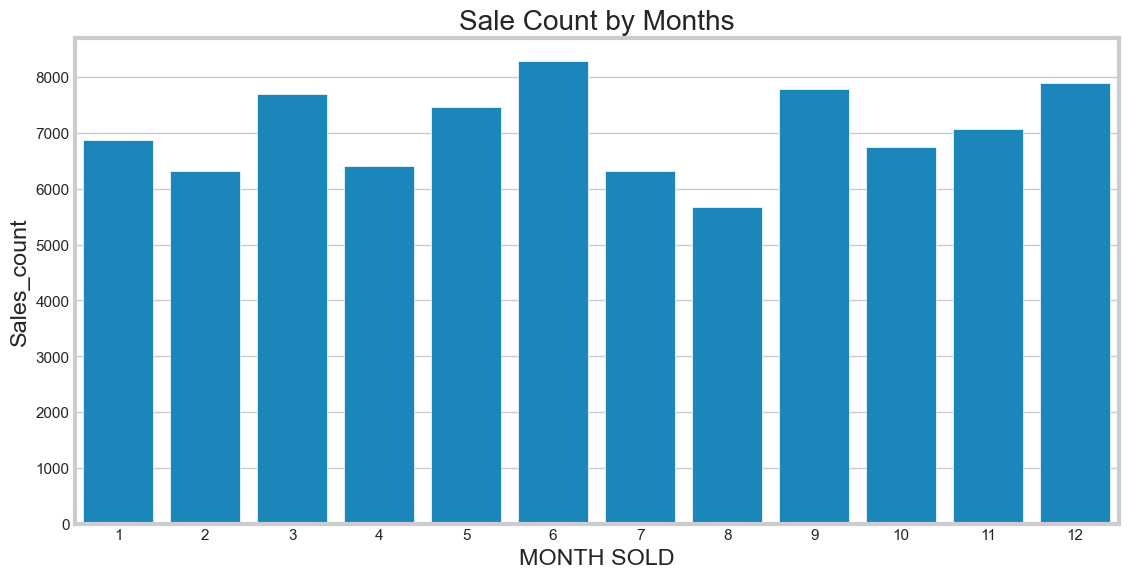

In [415]:
df_bar=df[['MONTH SOLD', 'SALE PRICE']].groupby(by='MONTH SOLD').count().sort_values(by='MONTH SOLD', ascending=True).reset_index()
df_bar.columns.values[1]='Sales_count'

plt.figure(figsize=(12,6))
sns.barplot(y = 'Sales_count', x = 'MONTH SOLD', data = df_bar)
plt.title('Sale Count by Months')
plt.show()

Text(0.5, 1.0, 'Sale Prices by Commercial Units')

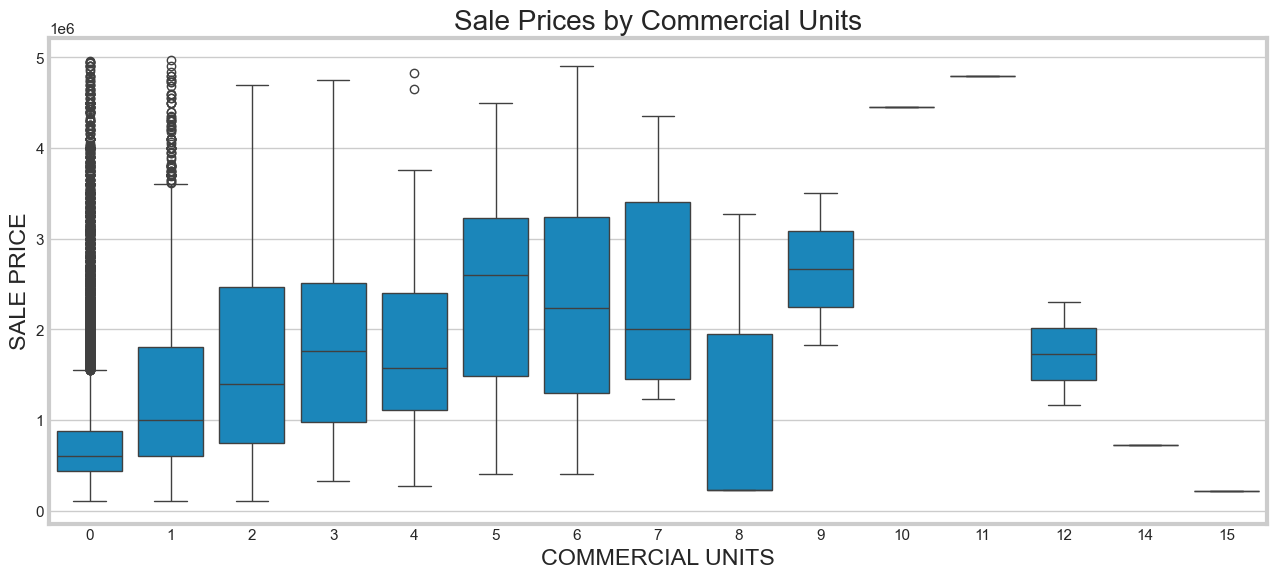

In [416]:
dataset = df[
    (df['COMMERCIAL UNITS']<20) & (df['TOTAL UNITS']<50) & 
    (df['SALE PRICE']<5000000) & (df['SALE PRICE']>100000) & 
    (df['GROSS SQUARE FEET']>0)
    ]

plt.figure(figsize=(14,6))
sns.boxplot(x='COMMERCIAL UNITS', y="SALE PRICE", data=dataset)
plt.title('Sale Prices by Commercial Units')

<a id='3'></a><center> <h2 style="background-color:green; color:white" ><br>3. DATA PREPROCESSING  <br></h2>

In [417]:
def get_categorical_and_numeric_columns(dataframe, number_of_unique_classes):
    categorical_columns = [col for col in dataframe.columns if len(dataframe[col].unique()) <= number_of_unique_classes
                          or dataframe[col].dtype == "O"]
    
    new_categorical_columns = []
    for cat_cols in categorical_columns:
        new_categorical_columns.append(cat_cols)
        
    numeric_columns = [col for col in dataframe.columns if len(dataframe[col].unique()) > number_of_unique_classes
                       and dataframe[col].dtype != "O" or col not in new_categorical_columns]
    numeric_columns.remove(cons.target_variable)  
    return new_categorical_columns, numeric_columns

def unique_value_analysis(dataframe, number_of_unique_classes):
    check_flag = 0
    for i in range(0, len(number_of_unique_classes)):
        cat_cols, num_cols = get_categorical_and_numeric_columns(dataframe, number_of_unique_classes[i])
        print('Number of Unique Value:',number_of_unique_classes[i],' Number of Categorical Value:',len(cat_cols),' Number of Numerical Value: ', len(num_cols))
        if check_flag < len(cat_cols)*1.1 and check_flag > 0:
            return number_of_unique_classes[i]
        else:
            check_flag = len(cat_cols)

In [418]:
threshold_value = unique_value_analysis(df,[2, 3, 5, 10, 20, 50])
print("threshold_value: ", threshold_value)
cat_cols, num_cols = get_categorical_and_numeric_columns(df, threshold_value)

Number of Unique Value: 2  Number of Categorical Value: 8  Number of Numerical Value:  7
Number of Unique Value: 3  Number of Categorical Value: 8  Number of Numerical Value:  7
threshold_value:  3


In [419]:
df[cat_cols].head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BUILDING CLASS AT PRESENT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,YEAR SOLD
4,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,C2,2,C2,2017
5,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,C7,2,C7,2016
6,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,C7,2,C7,2016
7,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,C4,2,C4,2016
8,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,C2,2,C2,2016


In [420]:
df[num_cols].head()

,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,MONTH SOLD,BUILDING AGE
4,5,0,5,"1,633",6440,7,117
5,28,3,31,"4,616",18690,12,117
6,16,1,17,"2,212",7803,12,117
7,10,0,10,"2,272",6794,9,104
8,6,0,6,"2,369",4615,11,117


In [421]:
#################### FILLING MISSING VALUES #########################

In [422]:
#### MISSING DATA ANALYSIS

df.replace(' ',np.nan, inplace=True)
round(df.isna().sum() /len(df) *100,2)

BOROUGH                           0
NEIGHBORHOOD                      0
BUILDING CLASS CATEGORY           0
TAX CLASS AT PRESENT              1
BUILDING CLASS AT PRESENT         1
RESIDENTIAL UNITS                 0
COMMERCIAL UNITS                  0
TOTAL UNITS                       0
LAND SQUARE FEET                 31
GROSS SQUARE FEET                 0
TAX CLASS AT TIME OF SALE         0
BUILDING CLASS AT TIME OF SALE    0
SALE PRICE                        0
MONTH SOLD                        0
YEAR SOLD                         0
BUILDING AGE                      0
dtype: float64

In [423]:
def missing_values_table(dataframe):
    variables_with_na = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[variables_with_na].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[variables_with_na].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    missing_df.reset_index(inplace=True)
    missing_df = missing_df.rename(columns = {'index':'Columns Name'})
    return missing_df
##################################################################################################################

def missing_vs_target(dataframe,target,variable_with_na):
    temp_df = dataframe.copy()
    for variable in variable_with_na:
        temp_df[variable + '_NA_FLAG'] = np.where(temp_df[variable].isnull(), 1, 0)    
    flags_na = temp_df.loc[:, temp_df.columns.str.contains('_NA_')].columns
    for variable in flags_na:
        print(pd.DataFrame({'TARGET_MEAN': temp_df.groupby(variable)[target].mean()}),end='\n\n\n')

missing_df = missing_values_table(df)
missing_df

,Columns Name,n_miss,ratio
0,LAND SQUARE FEET,26252,31
1,TAX CLASS AT PRESENT,738,1
2,BUILDING CLASS AT PRESENT,738,1


In [424]:
missing_drop_list = missing_df[missing_df['ratio']>40]['Columns Name'].values.tolist()
print(len(missing_drop_list), 'number of columns are removed.')
df.drop(missing_drop_list, axis=1, inplace=True)

0 number of columns are removed.


<Axes: >

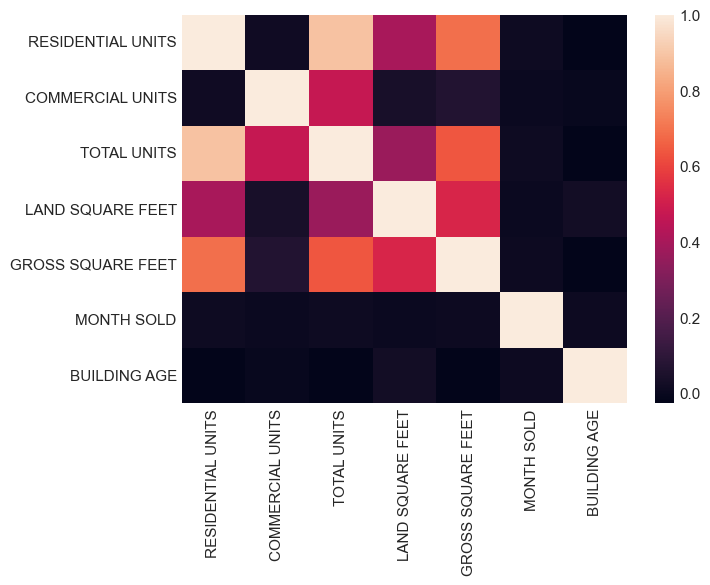

In [425]:
sns.heatmap(df[num_cols].corr()) #, annot= True)

We see a huge correlation between RESIDENTIAL UNITS and TOTAL UNITS. Correlated features in general don't improve models so we will keep only one of these features.

In [426]:
df.drop(["RESIDENTIAL UNITS"], axis = 1, inplace = True)
cat_cols, num_cols = get_categorical_and_numeric_columns(df, threshold_value)

In [427]:
# Imputing missing values in 'LAND SQUARE FEET' and 'GROSS SQUARE FEET' using the median
for col in ['LAND SQUARE FEET', 'GROSS SQUARE FEET']:
    median_value = df[col].median()
    df[col].fillna(median_value, inplace=True)

# Removing rows where 'SALE PRICE' is missing
# Deleting 0 price transfer transactions
# Deleting nan values of dependence variable

df = df[df["SALE PRICE"] > 0]  
df = df[df["SALE PRICE"].notnull()] 


df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59759 entries, 4 to 8413
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   BOROUGH                         59759 non-null  object 
 1   NEIGHBORHOOD                    59759 non-null  object 
 2   BUILDING CLASS CATEGORY         59759 non-null  object 
 3   TAX CLASS AT PRESENT            59166 non-null  object 
 4   BUILDING CLASS AT PRESENT       59166 non-null  object 
 5   COMMERCIAL UNITS                59759 non-null  int64  
 6   TOTAL UNITS                     59759 non-null  int64  
 7   LAND SQUARE FEET                59759 non-null  float64
 8   GROSS SQUARE FEET               59759 non-null  int32  
 9   TAX CLASS AT TIME OF SALE       59759 non-null  object 
 10  BUILDING CLASS AT TIME OF SALE  59759 non-null  object 
 11  SALE PRICE                      59759 non-null  float64
 12  MONTH SOLD                      59759 

In [428]:
# Square feet should not be 0.
#df = df[df["LAND SQUARE FEET"] != 0]
#df = df[df["GROSS SQUARE FEET"] != 0]
#df = df.dropna() 

df.drop_duplicates(keep = "last", inplace=True)

In [429]:
df_after_missing = df.copy()

In [430]:
# Removing data where commercial + residential doesn't equal total units
#df = df[df['TOTAL UNITS'] == df['COMMERCIAL UNITS'] + df['RESIDENTIAL UNITS']]
#df[["TOTAL UNITS", "SALE PRICE"]].groupby(['TOTAL UNITS'], as_index=False).count().sort_values(by='SALE PRICE', ascending=False).tail(10)

In [431]:
################ OUTLIER ANALYSIS

In [432]:
# Removing rows with TOTAL UNITS == 0 and one outlier with 2261 units
df = df[(df['TOTAL UNITS'] >= 0) & (df['TOTAL UNITS'] != 2261)]

df.shape

(58994, 15)

In [433]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.25)
    quartile3 = dataframe[variable].quantile(0.75)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit
##################################################################################################################

def replace_with_thresholds(dataframe, columns_list):
    for variable in columns_list:
        print(variable)
        low_limit, up_limit = outlier_thresholds(dataframe, variable)
        if low_limit < 0:
            low_limit = 0
        dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
        dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
##################################################################################################################

def remove_outliers(dataframe, numeric_columns):
    for variable in numeric_columns:
        low_limit, up_limit = outlier_thresholds(dataframe, variable)
        dataframe_without_outliers = dataframe[~((dataframe[variable] < low_limit) | (dataframe[variable] > up_limit))]
    return dataframe_without_outliers
##################################################################################################################

def has_outliers(dataframe, num_col_names, plot=False):
    variable_names = []
    for col in num_col_names:
        low_limit, up_limit = outlier_thresholds(dataframe, col)
        if dataframe[(dataframe[col] > up_limit) | (dataframe[col] < low_limit)].any(axis=None):
            number_of_outliers = dataframe[(dataframe[col] > up_limit) | (dataframe[col] < low_limit)].shape[0]
            print(col, ":", number_of_outliers)
            variable_names.append(col)
            if plot:
                sns.boxplot(x=dataframe[col])
                plt.show()
    return variable_names

In [434]:
outlier_variable_names = has_outliers(df, num_cols)

COMMERCIAL UNITS : 2768
TOTAL UNITS : 1616
LAND SQUARE FEET : 18572
GROSS SQUARE FEET : 2316
BUILDING AGE : 4253


In [435]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BUILDING CLASS AT PRESENT,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,MONTH SOLD,YEAR SOLD,BUILDING AGE
4,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,C2,0,5,"1,633",6440,2,C2,"6,625,000",7,2017,117
7,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,C4,0,10,"2,272",6794,2,C4,"3,936,272",9,2016,104
8,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,C2,0,6,"2,369",4615,2,C2,"8,000,000",11,2016,117
10,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,C4,0,8,"1,750",4226,2,C4,"3,192,840",9,2016,97
13,Manhattan,ALPHABET CITY,08 RENTALS - ELEVATOR APARTMENTS,2,D9,0,24,"4,489",18523,2,D9,"16,232,000",11,2016,97


In [436]:
replace_with_thresholds(df, outlier_variable_names)

COMMERCIAL UNITS
TOTAL UNITS
LAND SQUARE FEET
GROSS SQUARE FEET
BUILDING AGE


In [437]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BUILDING CLASS AT PRESENT,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,MONTH SOLD,YEAR SOLD,BUILDING AGE
4,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,C2,0,5,"1,633",4630,2,C2,"6,625,000",7,2017,117
7,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,C4,0,5,"2,272",4630,2,C4,"3,936,272",9,2016,104
8,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,C2,0,5,"2,369",4615,2,C2,"8,000,000",11,2016,117
10,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,C4,0,5,"1,750",4226,2,C4,"3,192,840",9,2016,97
13,Manhattan,ALPHABET CITY,08 RENTALS - ELEVATOR APARTMENTS,2,D9,0,5,"3,250",4630,2,D9,"16,232,000",11,2016,97


In [438]:
# Deleting of unnecessary categorical variables for the model

del df["NEIGHBORHOOD"]
del df['BUILDING CLASS AT TIME OF SALE']
del df['TAX CLASS AT PRESENT']
#del df['TAX CLASS AT TIME OF SALE']
#del df["BUILDING CLASS CATEGORY"]
del df["BUILDING CLASS AT PRESENT"]
del df["YEAR SOLD"]
del df["TOTAL UNITS"]

In [441]:
cat_cols, num_cols = get_categorical_and_numeric_columns(df, threshold_value)

# Removing exceding skewness from features
for col in num_cols:
    if df[col].skew() > 1:
        df[col] = np.log1p(df[col])

In [442]:
round(df.describe([0.75,0.85,0.95,0.99,0.995,0.999]),3)

,COMMERCIAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,SALE PRICE,MONTH SOLD,BUILDING AGE
count,"58,994","58,994","58,994","58,994","58,994","58,994"
mean,0,"2,287",4,"1,504,899",7,73
std,0,620,4,"12,402,280",3,41
min,0,"1,250",0,1,1,0
50%,0,"2,325",0,"630,000",6,77
75%,0,"2,500",8,"1,079,978",9,97
85%,0,"3,250",8,"1,600,000",11,107
95%,0,"3,250",8,"4,000,000",12,164
99%,0,"3,250",8,"14,000,000",12,164
99.5%,0,"3,250",8,"23,403,500",12,164


In [443]:
#Fixing all column names to be lowercase and no spaces
#df.columns = df.columns.str.lower().str.replace(' ', '_')
#df.tax_class_at_time_of_sale = df.tax_class_at_time_of_sale.astype(object)

In [444]:
round(df.isna().sum() /len(df) *100,2)

BOROUGH                     0
BUILDING CLASS CATEGORY     0
COMMERCIAL UNITS            0
LAND SQUARE FEET            0
GROSS SQUARE FEET           0
TAX CLASS AT TIME OF SALE   0
SALE PRICE                  0
MONTH SOLD                  0
BUILDING AGE                0
dtype: float64

In [445]:
df = df.dropna() 

In [446]:
# Creating dummy variables from categorical variables

one_hot_variables = ["BOROUGH", "BUILDING CLASS CATEGORY", "TAX CLASS AT TIME OF SALE"]
df = pd.get_dummies(df, columns=one_hot_variables, prefix_sep = "_" , drop_first = True)
#df.drop(one_hot_variables, axis = 1, inplace = True)

In [447]:
df.head()

,COMMERCIAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,SALE PRICE,MONTH SOLD,BUILDING AGE,BOROUGH_Brooklyn,BOROUGH_Manhattan,BOROUGH_Queens,BOROUGH_Staten Island,BUILDING CLASS CATEGORY_02 TWO FAMILY DWELLINGS,BUILDING CLASS CATEGORY_03 THREE FAMILY DWELLINGS,BUILDING CLASS CATEGORY_04 TAX CLASS 1 CONDOS,BUILDING CLASS CATEGORY_05 TAX CLASS 1 VACANT LAND,BUILDING CLASS CATEGORY_06 TAX CLASS 1 - OTHER,BUILDING CLASS CATEGORY_07 RENTALS - WALKUP APARTMENTS,BUILDING CLASS CATEGORY_08 RENTALS - ELEVATOR APARTMENTS,BUILDING CLASS CATEGORY_09 COOPS - WALKUP APARTMENTS,BUILDING CLASS CATEGORY_10 COOPS - ELEVATOR APARTMENTS,BUILDING CLASS CATEGORY_11 SPECIAL CONDO BILLING LOTS,BUILDING CLASS CATEGORY_11A CONDO-RENTALS,BUILDING CLASS CATEGORY_12 CONDOS - WALKUP APARTMENTS,BUILDING CLASS CATEGORY_13 CONDOS - ELEVATOR APARTMENTS,BUILDING CLASS CATEGORY_14 RENTALS - 4-10 UNIT,BUILDING CLASS CATEGORY_15 CONDOS - 2-10 UNIT RESIDENTIAL,BUILDING CLASS CATEGORY_16 CONDOS - 2-10 UNIT WITH COMMERCIAL UNIT,BUILDING CLASS CATEGORY_17 CONDO COOPS,BUILDING CLASS CATEGORY_21 OFFICE BUILDINGS,BUILDING CLASS CATEGORY_22 STORE BUILDINGS,BUILDING CLASS CATEGORY_23 LOFT BUILDINGS,BUILDING CLASS CATEGORY_25 LUXURY HOTELS,BUILDING CLASS CATEGORY_26 OTHER HOTELS,BUILDING CLASS CATEGORY_27 FACTORIES,BUILDING CLASS CATEGORY_28 COMMERCIAL CONDOS,BUILDING CLASS CATEGORY_29 COMMERCIAL GARAGES,BUILDING CLASS CATEGORY_30 WAREHOUSES,BUILDING CLASS CATEGORY_31 COMMERCIAL VACANT LAND,BUILDING CLASS CATEGORY_32 HOSPITAL AND HEALTH FACILITIES,BUILDING CLASS CATEGORY_33 EDUCATIONAL FACILITIES,BUILDING CLASS CATEGORY_34 THEATRES,BUILDING CLASS CATEGORY_35 INDOOR PUBLIC AND CULTURAL FACILITIES,BUILDING CLASS CATEGORY_36 OUTDOOR RECREATIONAL FACILITIES,BUILDING CLASS CATEGORY_37 RELIGIOUS FACILITIES,BUILDING CLASS CATEGORY_38 ASYLUMS AND HOMES,BUILDING CLASS CATEGORY_39 TRANSPORTATION FACILITIES,BUILDING CLASS CATEGORY_40 SELECTED GOVERNMENTAL FACILITIES,BUILDING CLASS CATEGORY_41 TAX CLASS 4 - OTHER,BUILDING CLASS CATEGORY_42 CONDO CULTURAL/MEDICAL/EDUCATIONAL/ETC,BUILDING CLASS CATEGORY_43 CONDO OFFICE BUILDINGS,BUILDING CLASS CATEGORY_44 CONDO PARKING,BUILDING CLASS CATEGORY_45 CONDO HOTELS,BUILDING CLASS CATEGORY_46 CONDO STORE BUILDINGS,BUILDING CLASS CATEGORY_47 CONDO NON-BUSINESS STORAGE,BUILDING CLASS CATEGORY_48 CONDO TERRACES/GARDENS/CABANAS,BUILDING CLASS CATEGORY_49 CONDO WAREHOUSES/FACTORY/INDUS,TAX CLASS AT TIME OF SALE_2,TAX CLASS AT TIME OF SALE_4
4,0,"1,633",8,"6,625,000",7,117,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
7,0,"2,272",8,"3,936,272",9,104,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
8,0,"2,369",8,"8,000,000",11,117,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
10,0,"1,750",8,"3,192,840",9,97,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
13,0,"3,250",8,"16,232,000",11,97,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,F

In [ ]:
#del df["residential_units"]
#del df["total_units"]
#del df["building_age"]
#del df["tax_class_at_present"]
#del df["building_class_at_time_of_sale"]

In [ ]:
######################FEATURE SCALING

In [448]:
##################################################################################################################
def robust_scaler(variable):
    var_median = variable.median()
    quartile1 = variable.quantile(0.25)
    quartile3 = variable.quantile(0.75)
    interquantile_range = quartile3 - quartile1
    if int(interquantile_range) == 0:
        quartile1 = variable.quantile(0.05)
        quartile3 = variable.quantile(0.95)
        interquantile_range = quartile3 - quartile1
        if int(interquantile_range) == 0:
            quartile1 = variable.quantile(0.10)
            quartile3 = variable.quantile(0.99)
            interquantile_range = quartile3 - quartile1
            z = (variable - var_median) / interquantile_range
            return round(z, 3)
        z = (variable - var_median) / interquantile_range
        return round(z, 3)
    else:
        z = (variable - var_median) / interquantile_range
    return round(z, 3)
##################################################################################################################

In [449]:
cat_cols, num_cols = get_categorical_and_numeric_columns(df, threshold_value)
for col in num_cols:
    df[col] = robust_scaler(df[col])
df.head()

,COMMERCIAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,SALE PRICE,MONTH SOLD,BUILDING AGE,BOROUGH_Brooklyn,BOROUGH_Manhattan,BOROUGH_Queens,BOROUGH_Staten Island,BUILDING CLASS CATEGORY_02 TWO FAMILY DWELLINGS,BUILDING CLASS CATEGORY_03 THREE FAMILY DWELLINGS,BUILDING CLASS CATEGORY_04 TAX CLASS 1 CONDOS,BUILDING CLASS CATEGORY_05 TAX CLASS 1 VACANT LAND,BUILDING CLASS CATEGORY_06 TAX CLASS 1 - OTHER,BUILDING CLASS CATEGORY_07 RENTALS - WALKUP APARTMENTS,BUILDING CLASS CATEGORY_08 RENTALS - ELEVATOR APARTMENTS,BUILDING CLASS CATEGORY_09 COOPS - WALKUP APARTMENTS,BUILDING CLASS CATEGORY_10 COOPS - ELEVATOR APARTMENTS,BUILDING CLASS CATEGORY_11 SPECIAL CONDO BILLING LOTS,BUILDING CLASS CATEGORY_11A CONDO-RENTALS,BUILDING CLASS CATEGORY_12 CONDOS - WALKUP APARTMENTS,BUILDING CLASS CATEGORY_13 CONDOS - ELEVATOR APARTMENTS,BUILDING CLASS CATEGORY_14 RENTALS - 4-10 UNIT,BUILDING CLASS CATEGORY_15 CONDOS - 2-10 UNIT RESIDENTIAL,BUILDING CLASS CATEGORY_16 CONDOS - 2-10 UNIT WITH COMMERCIAL UNIT,BUILDING CLASS CATEGORY_17 CONDO COOPS,BUILDING CLASS CATEGORY_21 OFFICE BUILDINGS,BUILDING CLASS CATEGORY_22 STORE BUILDINGS,BUILDING CLASS CATEGORY_23 LOFT BUILDINGS,BUILDING CLASS CATEGORY_25 LUXURY HOTELS,BUILDING CLASS CATEGORY_26 OTHER HOTELS,BUILDING CLASS CATEGORY_27 FACTORIES,BUILDING CLASS CATEGORY_28 COMMERCIAL CONDOS,BUILDING CLASS CATEGORY_29 COMMERCIAL GARAGES,BUILDING CLASS CATEGORY_30 WAREHOUSES,BUILDING CLASS CATEGORY_31 COMMERCIAL VACANT LAND,BUILDING CLASS CATEGORY_32 HOSPITAL AND HEALTH FACILITIES,BUILDING CLASS CATEGORY_33 EDUCATIONAL FACILITIES,BUILDING CLASS CATEGORY_34 THEATRES,BUILDING CLASS CATEGORY_35 INDOOR PUBLIC AND CULTURAL FACILITIES,BUILDING CLASS CATEGORY_36 OUTDOOR RECREATIONAL FACILITIES,BUILDING CLASS CATEGORY_37 RELIGIOUS FACILITIES,BUILDING CLASS CATEGORY_38 ASYLUMS AND HOMES,BUILDING CLASS CATEGORY_39 TRANSPORTATION FACILITIES,BUILDING CLASS CATEGORY_40 SELECTED GOVERNMENTAL FACILITIES,BUILDING CLASS CATEGORY_41 TAX CLASS 4 - OTHER,BUILDING CLASS CATEGORY_42 CONDO CULTURAL/MEDICAL/EDUCATIONAL/ETC,BUILDING CLASS CATEGORY_43 CONDO OFFICE BUILDINGS,BUILDING CLASS CATEGORY_44 CONDO PARKING,BUILDING CLASS CATEGORY_45 CONDO HOTELS,BUILDING CLASS CATEGORY_46 CONDO STORE BUILDINGS,BUILDING CLASS CATEGORY_47 CONDO NON-BUSINESS STORAGE,BUILDING CLASS CATEGORY_48 CONDO TERRACES/GARDENS/CABANAS,BUILDING CLASS CATEGORY_49 CONDO WAREHOUSES/FACTORY/INDUS,TAX CLASS AT TIME OF SALE_2,TAX CLASS AT TIME OF SALE_4
4,0,-1,1,"6,625,000",0,1,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
7,0,-0,1,"3,936,272",1,1,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
8,0,0,1,"8,000,000",1,1,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
10,0,-1,1,"3,192,840",1,0,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
13,0,2,1,"16,232,000",1,0,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fa

In [450]:
target_variable = "SALE PRICE"

def df_split(df):    
    X = df.drop(target_variable, axis=1)
    y = df[target_variable].astype(int)
    X = X.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) 
    return X_train, X_test, y_train, y_test

In [453]:
X_train, X_test, y_train, y_test  = df_split(df)

model = LGBMRegressor().fit(X_train,y_train)
cv = KFold(n_splits=5, shuffle=True, random_state=0)
dataset = Dataset(df = df, target = target_variable, features = [col for col in df.columns if col != target_variable])
lofo_imp = LOFOImportance(dataset, cv=cv, model=model, scoring="r2", n_jobs=-1)
importance_df = lofo_imp.get_importance()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000397 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 698
[LightGBM] [Info] Number of data points in the train set: 47195, number of used features: 42
[LightGBM] [Info] Start training from score 1422939.336540
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001371 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 698
[LightGBM] [Info] Number of data points in the train set: 47195, number of used features: 42
[LightGBM] [Info] Start training from score 1515268.683293
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

  0%|          | 0/56 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 472
[LightGBM] [Info] Number of data points in the train set: 47195, number of used features: 41
[LightGBM] [Info] Start training from score 1515268.683293
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001553 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 471
[LightGBM] [Info] Number of data points in the train set: 47195, number of used features: 41
[LightGBM] [Info] Start training from score 1515659.735184
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001632 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

  2%|▏         | 1/56 [00:01<01:08,  1.25s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 471
[LightGBM] [Info] Number of data points in the train set: 47196, number of used features: 40
[LightGBM] [Info] Start training from score 1493049.506653
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001846 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 47195, number of used features: 41
[LightGBM] [Info] Start training from score 1515268.683293
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001762 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

  4%|▎         | 2/56 [00:02<01:10,  1.31s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 694
[LightGBM] [Info] Number of data points in the train set: 47196, number of used features: 40
[LightGBM] [Info] Start training from score 1493049.506653
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001924 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 698
[LightGBM] [Info] Number of data points in the train set: 47195, number of used features: 42
[LightGBM] [Info] Start training from score 1515268.683293
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002711 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

  5%|▌         | 3/56 [00:04<01:27,  1.64s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002164 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 47195, number of used features: 41
[LightGBM] [Info] Start training from score 1515268.683293
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002168 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 695
[LightGBM] [Info] Number of data points in the train set: 47195, number of used features: 41
[LightGBM] [Info] Start training from score 1515659.735184
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002421 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

  7%|▋         | 4/56 [00:06<01:30,  1.75s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 47195, number of used features: 41
[LightGBM] [Info] Start training from score 1515268.683293
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002586 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 695
[LightGBM] [Info] Number of data points in the train set: 47195, number of used features: 41
[LightGBM] [Info] Start training from score 1515659.735184
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

  9%|▉         | 5/56 [00:08<01:32,  1.81s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001289 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 47195, number of used features: 41
[LightGBM] [Info] Start training from score 1515268.683293
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 695
[LightGBM] [Info] Number of data points in the train set: 47195, number of used features: 41
[LightGBM] [Info] Start training from score 1515659.735184
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001733 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

 11%|█         | 6/56 [00:09<01:21,  1.64s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 694
[LightGBM] [Info] Number of data points in the train set: 47196, number of used features: 40
[LightGBM] [Info] Start training from score 1493049.506653
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 698
[LightGBM] [Info] Number of data points in the train set: 47195, number of used features: 42
[LightGBM] [Info] Start training from score 1515268.683293
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003012 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

 12%|█▎        | 7/56 [00:11<01:16,  1.55s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 47196, number of used features: 41
[LightGBM] [Info] Start training from score 1493049.506653
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 698
[LightGBM] [Info] Number of data points in the train set: 47195, number of used features: 42
[LightGBM] [Info] Start training from score 1515268.683293
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

 14%|█▍        | 8/56 [00:12<01:08,  1.42s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001152 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 47196, number of used features: 41
[LightGBM] [Info] Start training from score 1493049.506653
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001571 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 698
[LightGBM] [Info] Number of data points in the train set: 47195, number of used features: 42
[LightGBM] [Info] Start training from score 1515268.683293
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

 16%|█▌        | 9/56 [00:13<01:02,  1.33s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 47196, number of used features: 41
[LightGBM] [Info] Start training from score 1493049.506653
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 698
[LightGBM] [Info] Number of data points in the train set: 47195, number of used features: 42
[LightGBM] [Info] Start training from score 1515268.683293
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001248 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

 18%|█▊        | 10/56 [00:14<00:59,  1.30s/it]

[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 47196, number of used features: 41
[LightGBM] [Info] Start training from score 1493049.506653
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 47195, number of used features: 41
[LightGBM] [Info] Start training from score 1515268.683293
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 695
[LightGBM] [Info] Number of data points in the train set: 47195, number of used features: 41
[LightGBM] [Info] Start training from score 1515659.

 20%|█▉        | 11/56 [00:15<00:58,  1.30s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 694
[LightGBM] [Info] Number of data points in the train set: 47196, number of used features: 40
[LightGBM] [Info] Start training from score 1493049.506653
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 698
[LightGBM] [Info] Number of data points in the train set: 47195, number of used features: 42
[LightGBM] [Info] Start training from score 1515268.683293
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001358 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

 21%|██▏       | 12/56 [00:17<00:55,  1.26s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001719 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 47196, number of used features: 41
[LightGBM] [Info] Start training from score 1493049.506653
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000959 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 47195, number of used features: 41
[LightGBM] [Info] Start training from score 1515268.683293
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000981 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

 23%|██▎       | 13/56 [00:18<00:53,  1.24s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001017 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 694
[LightGBM] [Info] Number of data points in the train set: 47196, number of used features: 40
[LightGBM] [Info] Start training from score 1493049.506653
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 47195, number of used features: 41
[LightGBM] [Info] Start training from score 1515268.683293
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001645 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

 25%|██▌       | 14/56 [00:19<00:52,  1.24s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 694
[LightGBM] [Info] Number of data points in the train set: 47196, number of used features: 40
[LightGBM] [Info] Start training from score 1493049.506653
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001339 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 698
[LightGBM] [Info] Number of data points in the train set: 47195, number of used features: 42
[LightGBM] [Info] Start training from score 1515268.683293
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001759 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

 27%|██▋       | 15/56 [00:20<00:52,  1.28s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001159 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 47196, number of used features: 41
[LightGBM] [Info] Start training from score 1493049.506653
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001510 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 47195, number of used features: 41
[LightGBM] [Info] Start training from score 1515268.683293
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002519 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

 29%|██▊       | 16/56 [00:22<00:53,  1.33s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 694
[LightGBM] [Info] Number of data points in the train set: 47196, number of used features: 40
[LightGBM] [Info] Start training from score 1493049.506653
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 47195, number of used features: 41
[LightGBM] [Info] Start training from score 1515268.683293
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

 30%|███       | 17/56 [00:23<00:50,  1.29s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001489 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 694
[LightGBM] [Info] Number of data points in the train set: 47196, number of used features: 40
[LightGBM] [Info] Start training from score 1493049.506653
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 47195, number of used features: 41
[LightGBM] [Info] Start training from score 1515268.683293
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

 32%|███▏      | 18/56 [00:24<00:48,  1.27s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 694
[LightGBM] [Info] Number of data points in the train set: 47196, number of used features: 40
[LightGBM] [Info] Start training from score 1493049.506653
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 47195, number of used features: 41
[LightGBM] [Info] Start training from score 1515268.683293
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

 34%|███▍      | 19/56 [00:26<00:48,  1.31s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 694
[LightGBM] [Info] Number of data points in the train set: 47196, number of used features: 40
[LightGBM] [Info] Start training from score 1493049.506653
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 47195, number of used features: 41
[LightGBM] [Info] Start training from score 1515268.683293
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000427 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

 36%|███▌      | 20/56 [00:27<00:47,  1.33s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 694
[LightGBM] [Info] Number of data points in the train set: 47196, number of used features: 40
[LightGBM] [Info] Start training from score 1493049.506653
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001514 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 698
[LightGBM] [Info] Number of data points in the train set: 47195, number of used features: 42
[LightGBM] [Info] Start training from score 1515268.683293
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001645 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

 38%|███▊      | 21/56 [00:28<00:45,  1.29s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 47196, number of used features: 41
[LightGBM] [Info] Start training from score 1493049.506653
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001182 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 698
[LightGBM] [Info] Number of data points in the train set: 47195, number of used features: 42
[LightGBM] [Info] Start training from score 1515268.683293
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001676 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

 39%|███▉      | 22/56 [00:30<00:44,  1.32s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 47196, number of used features: 41
[LightGBM] [Info] Start training from score 1493049.506653
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 47195, number of used features: 41
[LightGBM] [Info] Start training from score 1515268.683293
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

 41%|████      | 23/56 [00:31<00:43,  1.31s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 694
[LightGBM] [Info] Number of data points in the train set: 47196, number of used features: 40
[LightGBM] [Info] Start training from score 1493049.506653
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 444
[LightGBM] [Info] Number of data points in the train set: 47195, number of used features: 41
[LightGBM] [Info] Start training from score 1515268.683293
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001714 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

 43%|████▎     | 24/56 [00:32<00:41,  1.30s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001507 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 443
[LightGBM] [Info] Number of data points in the train set: 47196, number of used features: 40
[LightGBM] [Info] Start training from score 1493049.506653
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 686
[LightGBM] [Info] Number of data points in the train set: 47195, number of used features: 41
[LightGBM] [Info] Start training from score 1515268.683293
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

 45%|████▍     | 25/56 [00:33<00:39,  1.27s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 684
[LightGBM] [Info] Number of data points in the train set: 47196, number of used features: 40
[LightGBM] [Info] Start training from score 1493049.506653
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002802 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 698
[LightGBM] [Info] Number of data points in the train set: 47195, number of used features: 42
[LightGBM] [Info] Start training from score 1515268.683293
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001194 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

 46%|████▋     | 26/56 [00:35<00:37,  1.25s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001385 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 47196, number of used features: 41
[LightGBM] [Info] Start training from score 1493049.506653
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 47195, number of used features: 41
[LightGBM] [Info] Start training from score 1515268.683293
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

 48%|████▊     | 27/56 [00:36<00:36,  1.25s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 694
[LightGBM] [Info] Number of data points in the train set: 47196, number of used features: 40
[LightGBM] [Info] Start training from score 1493049.506653
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001167 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 698
[LightGBM] [Info] Number of data points in the train set: 47195, number of used features: 42
[LightGBM] [Info] Start training from score 1515268.683293
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001248 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

 50%|█████     | 28/56 [00:37<00:34,  1.24s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001152 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 47196, number of used features: 41
[LightGBM] [Info] Start training from score 1493049.506653
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001285 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 47195, number of used features: 41
[LightGBM] [Info] Start training from score 1515268.683293
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

 52%|█████▏    | 29/56 [00:38<00:33,  1.23s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001103 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 694
[LightGBM] [Info] Number of data points in the train set: 47196, number of used features: 40
[LightGBM] [Info] Start training from score 1493049.506653
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 47195, number of used features: 41
[LightGBM] [Info] Start training from score 1515268.683293
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001239 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

 54%|█████▎    | 30/56 [00:40<00:32,  1.24s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 694
[LightGBM] [Info] Number of data points in the train set: 47196, number of used features: 40
[LightGBM] [Info] Start training from score 1493049.506653
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 47195, number of used features: 41
[LightGBM] [Info] Start training from score 1515268.683293
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

 55%|█████▌    | 31/56 [00:41<00:31,  1.26s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 694
[LightGBM] [Info] Number of data points in the train set: 47196, number of used features: 40
[LightGBM] [Info] Start training from score 1493049.506653
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 47195, number of used features: 41
[LightGBM] [Info] Start training from score 1515268.683293
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

 57%|█████▋    | 32/56 [00:42<00:29,  1.24s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001273 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 694
[LightGBM] [Info] Number of data points in the train set: 47196, number of used features: 40
[LightGBM] [Info] Start training from score 1493049.506653
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001153 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 47195, number of used features: 41
[LightGBM] [Info] Start training from score 1515268.683293
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001715 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

 59%|█████▉    | 33/56 [00:43<00:28,  1.23s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 694
[LightGBM] [Info] Number of data points in the train set: 47196, number of used features: 40
[LightGBM] [Info] Start training from score 1493049.506653
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 698
[LightGBM] [Info] Number of data points in the train set: 47195, number of used features: 42
[LightGBM] [Info] Start training from score 1515268.683293
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

 61%|██████    | 34/56 [00:44<00:26,  1.22s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001252 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 47196, number of used features: 41
[LightGBM] [Info] Start training from score 1493049.506653
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 47195, number of used features: 41
[LightGBM] [Info] Start training from score 1515268.683293
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

 62%|██████▎   | 35/56 [00:46<00:25,  1.22s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 694
[LightGBM] [Info] Number of data points in the train set: 47196, number of used features: 40
[LightGBM] [Info] Start training from score 1493049.506653
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 47195, number of used features: 41
[LightGBM] [Info] Start training from score 1515268.683293
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

 64%|██████▍   | 36/56 [00:47<00:24,  1.21s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001731 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 47196, number of used features: 41
[LightGBM] [Info] Start training from score 1493049.506653
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 47195, number of used features: 41
[LightGBM] [Info] Start training from score 1515268.683293
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

 66%|██████▌   | 37/56 [00:48<00:22,  1.20s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001122 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 694
[LightGBM] [Info] Number of data points in the train set: 47196, number of used features: 40
[LightGBM] [Info] Start training from score 1493049.506653
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 47195, number of used features: 41
[LightGBM] [Info] Start training from score 1515268.683293
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001363 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

 68%|██████▊   | 38/56 [00:49<00:21,  1.20s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001447 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 694
[LightGBM] [Info] Number of data points in the train set: 47196, number of used features: 40
[LightGBM] [Info] Start training from score 1493049.506653
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001163 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 47195, number of used features: 41
[LightGBM] [Info] Start training from score 1515268.683293
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001167 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

 70%|██████▉   | 39/56 [00:50<00:20,  1.20s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 694
[LightGBM] [Info] Number of data points in the train set: 47196, number of used features: 40
[LightGBM] [Info] Start training from score 1493049.506653
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 698
[LightGBM] [Info] Number of data points in the train set: 47195, number of used features: 42
[LightGBM] [Info] Start training from score 1515268.683293
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

 71%|███████▏  | 40/56 [00:52<00:19,  1.23s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001269 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 47196, number of used features: 41
[LightGBM] [Info] Start training from score 1493049.506653
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 698
[LightGBM] [Info] Number of data points in the train set: 47195, number of used features: 42
[LightGBM] [Info] Start training from score 1515268.683293
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

 73%|███████▎  | 41/56 [00:53<00:18,  1.25s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 47196, number of used features: 41
[LightGBM] [Info] Start training from score 1493049.506653
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001397 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 47195, number of used features: 41
[LightGBM] [Info] Start training from score 1515268.683293
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

 75%|███████▌  | 42/56 [00:54<00:17,  1.25s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001289 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 694
[LightGBM] [Info] Number of data points in the train set: 47196, number of used features: 40
[LightGBM] [Info] Start training from score 1493049.506653
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 47195, number of used features: 41
[LightGBM] [Info] Start training from score 1515268.683293
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001267 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

 77%|███████▋  | 43/56 [00:56<00:16,  1.26s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 694
[LightGBM] [Info] Number of data points in the train set: 47196, number of used features: 40
[LightGBM] [Info] Start training from score 1493049.506653
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 568
[LightGBM] [Info] Number of data points in the train set: 47195, number of used features: 41
[LightGBM] [Info] Start training from score 1515268.683293
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

 79%|███████▊  | 44/56 [00:57<00:15,  1.26s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001179 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 564
[LightGBM] [Info] Number of data points in the train set: 47196, number of used features: 40
[LightGBM] [Info] Start training from score 1493049.506653
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001203 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 47195, number of used features: 41
[LightGBM] [Info] Start training from score 1515268.683293
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001400 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

 80%|████████  | 45/56 [00:58<00:13,  1.25s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 694
[LightGBM] [Info] Number of data points in the train set: 47196, number of used features: 40
[LightGBM] [Info] Start training from score 1493049.506653
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001190 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 47195, number of used features: 41
[LightGBM] [Info] Start training from score 1515268.683293
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001345 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

 82%|████████▏ | 46/56 [00:59<00:12,  1.25s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 694
[LightGBM] [Info] Number of data points in the train set: 47196, number of used features: 40
[LightGBM] [Info] Start training from score 1493049.506653
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001241 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 47195, number of used features: 41
[LightGBM] [Info] Start training from score 1515268.683293
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001781 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

 84%|████████▍ | 47/56 [01:01<00:11,  1.25s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 694
[LightGBM] [Info] Number of data points in the train set: 47196, number of used features: 40
[LightGBM] [Info] Start training from score 1493049.506653
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 47195, number of used features: 41
[LightGBM] [Info] Start training from score 1515268.683293
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000348 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

 86%|████████▌ | 48/56 [01:02<00:09,  1.24s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000275 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 694
[LightGBM] [Info] Number of data points in the train set: 47196, number of used features: 40
[LightGBM] [Info] Start training from score 1493049.506653
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001216 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 47195, number of used features: 41
[LightGBM] [Info] Start training from score 1515268.683293
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

 88%|████████▊ | 49/56 [01:03<00:08,  1.26s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001400 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 694
[LightGBM] [Info] Number of data points in the train set: 47196, number of used features: 40
[LightGBM] [Info] Start training from score 1493049.506653
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001715 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 47195, number of used features: 41
[LightGBM] [Info] Start training from score 1515268.683293
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

 89%|████████▉ | 50/56 [01:04<00:07,  1.25s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001387 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 694
[LightGBM] [Info] Number of data points in the train set: 47196, number of used features: 40
[LightGBM] [Info] Start training from score 1493049.506653
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001447 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 47195, number of used features: 41
[LightGBM] [Info] Start training from score 1515268.683293
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001322 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

 91%|█████████ | 51/56 [01:06<00:06,  1.26s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001200 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 694
[LightGBM] [Info] Number of data points in the train set: 47196, number of used features: 40
[LightGBM] [Info] Start training from score 1493049.506653
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001391 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 47195, number of used features: 41
[LightGBM] [Info] Start training from score 1515268.683293
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001396 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

 93%|█████████▎| 52/56 [01:07<00:05,  1.32s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001593 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 694
[LightGBM] [Info] Number of data points in the train set: 47196, number of used features: 40
[LightGBM] [Info] Start training from score 1493049.506653
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 47195, number of used features: 41
[LightGBM] [Info] Start training from score 1515268.683293
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001437 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

 95%|█████████▍| 53/56 [01:09<00:04,  1.47s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001416 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 694
[LightGBM] [Info] Number of data points in the train set: 47196, number of used features: 40
[LightGBM] [Info] Start training from score 1493049.506653
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 47195, number of used features: 41
[LightGBM] [Info] Start training from score 1515268.683293
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

 96%|█████████▋| 54/56 [01:10<00:02,  1.45s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001443 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 694
[LightGBM] [Info] Number of data points in the train set: 47196, number of used features: 40
[LightGBM] [Info] Start training from score 1493049.506653
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 47195, number of used features: 41
[LightGBM] [Info] Start training from score 1515268.683293
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

 98%|█████████▊| 55/56 [01:12<00:01,  1.40s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 694
[LightGBM] [Info] Number of data points in the train set: 47196, number of used features: 40
[LightGBM] [Info] Start training from score 1493049.506653
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 47195, number of used features: 41
[LightGBM] [Info] Start training from score 1515268.683293
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001353 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

100%|██████████| 56/56 [01:13<00:00,  1.31s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001312 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 694
[LightGBM] [Info] Number of data points in the train set: 47196, number of used features: 40
[LightGBM] [Info] Start training from score 1493049.506653


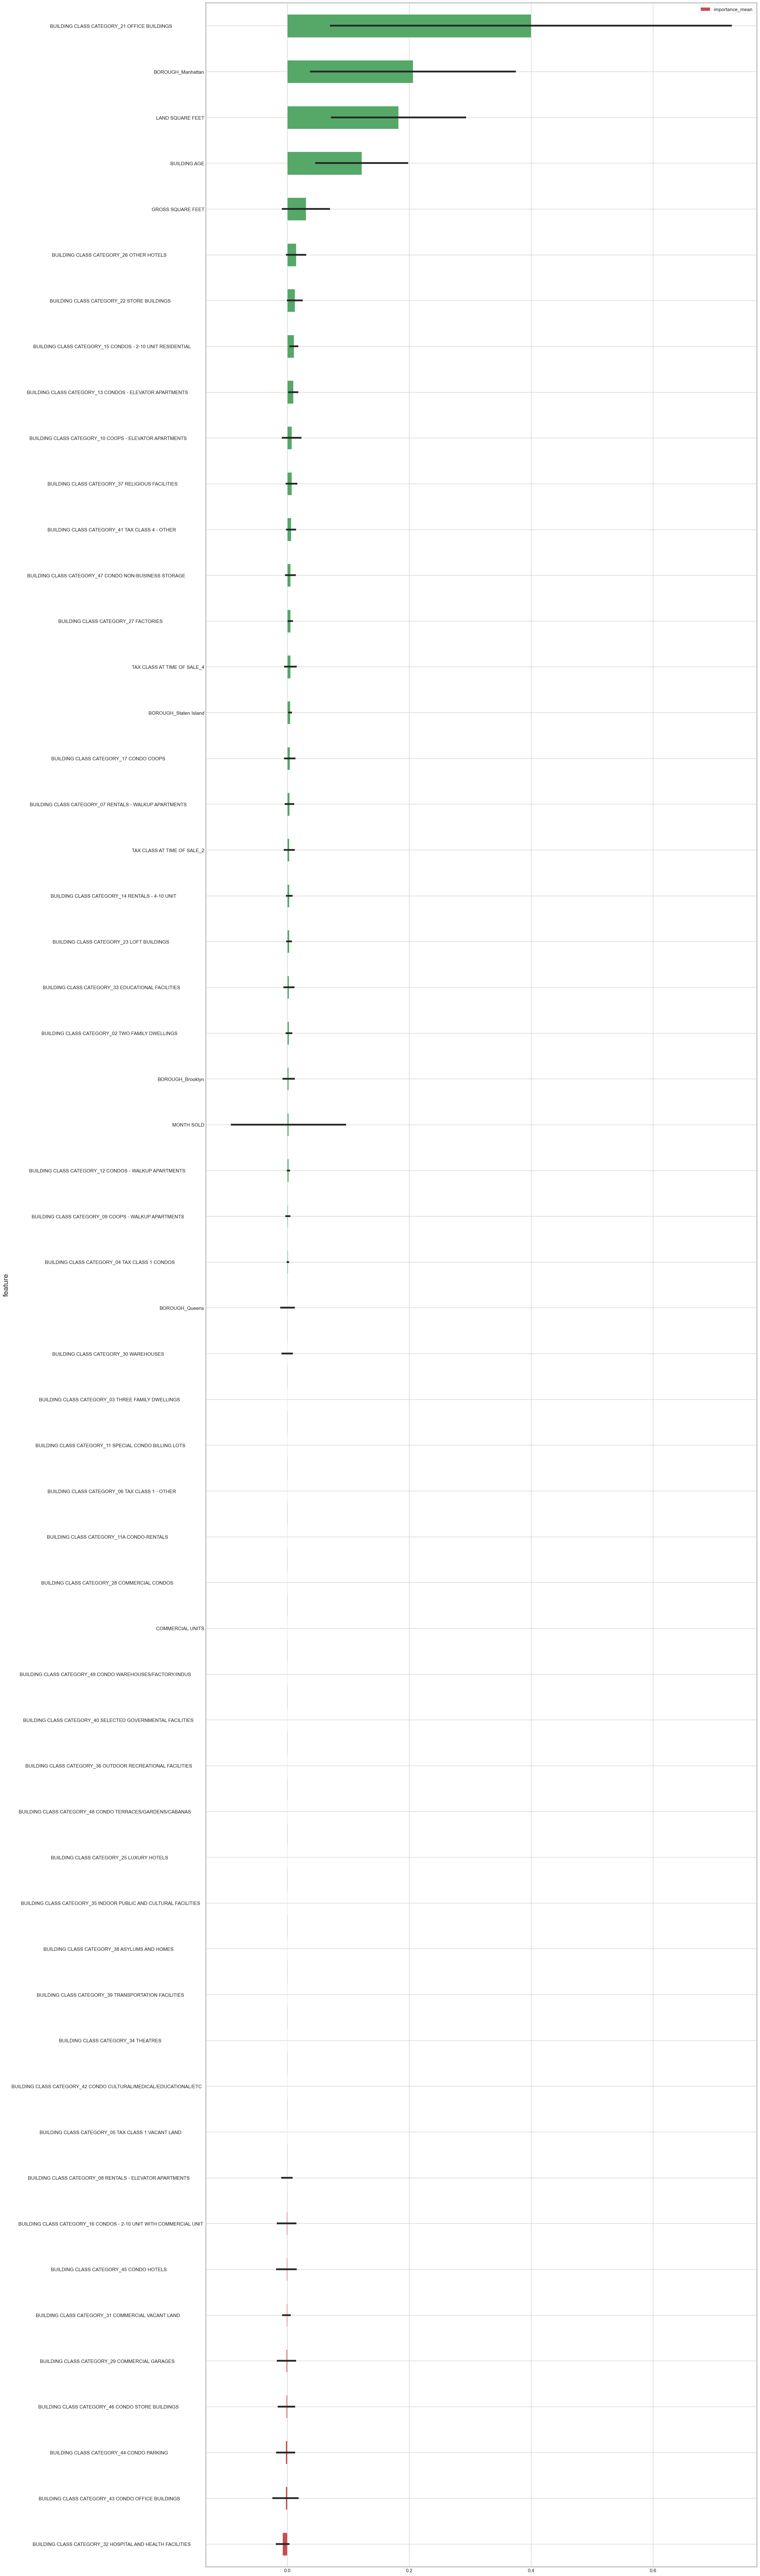

In [454]:
negative = importance_df[importance_df["importance_mean"] < 0]["feature"].tolist()
df.drop(negative, axis=1, inplace=True)
plot_importance(importance_df, figsize=(20, 100))
plt.show()

In [455]:
df.head()

,COMMERCIAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,SALE PRICE,MONTH SOLD,BUILDING AGE,BOROUGH_Brooklyn,BOROUGH_Manhattan,BOROUGH_Queens,BOROUGH_Staten Island,BUILDING CLASS CATEGORY_02 TWO FAMILY DWELLINGS,BUILDING CLASS CATEGORY_03 THREE FAMILY DWELLINGS,BUILDING CLASS CATEGORY_04 TAX CLASS 1 CONDOS,BUILDING CLASS CATEGORY_06 TAX CLASS 1 - OTHER,BUILDING CLASS CATEGORY_07 RENTALS - WALKUP APARTMENTS,BUILDING CLASS CATEGORY_09 COOPS - WALKUP APARTMENTS,BUILDING CLASS CATEGORY_10 COOPS - ELEVATOR APARTMENTS,BUILDING CLASS CATEGORY_11 SPECIAL CONDO BILLING LOTS,BUILDING CLASS CATEGORY_11A CONDO-RENTALS,BUILDING CLASS CATEGORY_12 CONDOS - WALKUP APARTMENTS,BUILDING CLASS CATEGORY_13 CONDOS - ELEVATOR APARTMENTS,BUILDING CLASS CATEGORY_14 RENTALS - 4-10 UNIT,BUILDING CLASS CATEGORY_15 CONDOS - 2-10 UNIT RESIDENTIAL,BUILDING CLASS CATEGORY_17 CONDO COOPS,BUILDING CLASS CATEGORY_21 OFFICE BUILDINGS,BUILDING CLASS CATEGORY_22 STORE BUILDINGS,BUILDING CLASS CATEGORY_23 LOFT BUILDINGS,BUILDING CLASS CATEGORY_25 LUXURY HOTELS,BUILDING CLASS CATEGORY_26 OTHER HOTELS,BUILDING CLASS CATEGORY_27 FACTORIES,BUILDING CLASS CATEGORY_28 COMMERCIAL CONDOS,BUILDING CLASS CATEGORY_30 WAREHOUSES,BUILDING CLASS CATEGORY_33 EDUCATIONAL FACILITIES,BUILDING CLASS CATEGORY_34 THEATRES,BUILDING CLASS CATEGORY_35 INDOOR PUBLIC AND CULTURAL FACILITIES,BUILDING CLASS CATEGORY_36 OUTDOOR RECREATIONAL FACILITIES,BUILDING CLASS CATEGORY_37 RELIGIOUS FACILITIES,BUILDING CLASS CATEGORY_38 ASYLUMS AND HOMES,BUILDING CLASS CATEGORY_39 TRANSPORTATION FACILITIES,BUILDING CLASS CATEGORY_40 SELECTED GOVERNMENTAL FACILITIES,BUILDING CLASS CATEGORY_41 TAX CLASS 4 - OTHER,BUILDING CLASS CATEGORY_42 CONDO CULTURAL/MEDICAL/EDUCATIONAL/ETC,BUILDING CLASS CATEGORY_47 CONDO NON-BUSINESS STORAGE,BUILDING CLASS CATEGORY_48 CONDO TERRACES/GARDENS/CABANAS,BUILDING CLASS CATEGORY_49 CONDO WAREHOUSES/FACTORY/INDUS,TAX CLASS AT TIME OF SALE_2,TAX CLASS AT TIME OF SALE_4
4,0,-1,1,"6,625,000",0,1,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
7,0,-0,1,"3,936,272",1,1,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
8,0,0,1,"8,000,000",1,1,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
10,0,-1,1,"3,192,840",1,0,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
13,0,2,1,"16,232,000",1,0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False


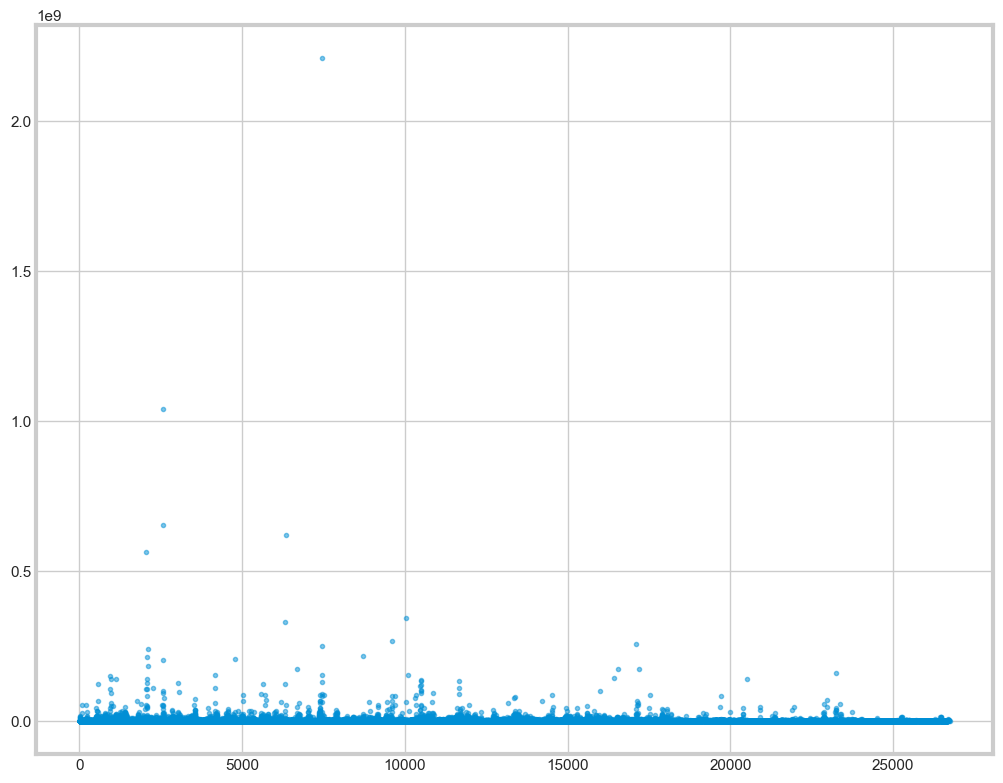

In [456]:
axes = df["SALE PRICE"].plot(
    marker='.',
    alpha=0.5,
    linestyle='',
    figsize=(11, 9),
    subplots=True
)

In [457]:
df = df[(df['SALE PRICE'] < 5e8) & (df['SALE PRICE'] > 1e5)]


df["SALE PRICE"].skew()

24.982192254814137

In [458]:
X_train, X_test, y_train, y_test  = df_split(df)

In [459]:
# Build and train model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict the sale prices on the test set
y_pred = model.predict(X_test)

# Evaluate the model performance
print(model.score(X_test, y_test))
print(mean_squared_error(y_test, y_pred) ** 0.5)

0.15586873300099702
5660452.595145346


In [460]:
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

R-squared: 0.15586873300099702


In [461]:
model.coef_

array([ 3.54450141e-12,  1.93510744e+05,  1.99320519e+06,  6.86578384e+04,
       -5.39763317e+03,  6.62250274e+05,  2.35561773e+06,  1.45491929e+05,
       -2.49128567e+05, -1.16008290e+05, -3.85438557e+04,  1.94991875e+06,
        1.38583756e+06, -1.61927038e+07, -1.70804854e+07, -1.71139660e+07,
       -1.94673182e+07,  2.97846839e+06, -1.65114928e+07, -1.60606445e+07,
       -1.69321322e+07, -1.59341407e+07, -1.76736199e+07,  1.04949827e+07,
       -3.35156857e+06,  9.81072946e+06,  1.38020286e+08,  3.02526952e+07,
       -2.14450610e+06,  2.33345050e+06, -1.70480622e+06, -2.99856039e+06,
        9.32561715e+06,  5.14355141e+06, -4.40807676e+06, -2.85555990e+06,
        8.77294139e+06, -5.37946038e+06,  8.87300601e+06,  3.07085539e+06,
        4.21474339e+07, -6.68514769e+06, -4.23972022e+06,  2.42143869e-08,
        1.81808052e+07,  6.00989043e+06])

<Axes: xlabel='SALE PRICE'>

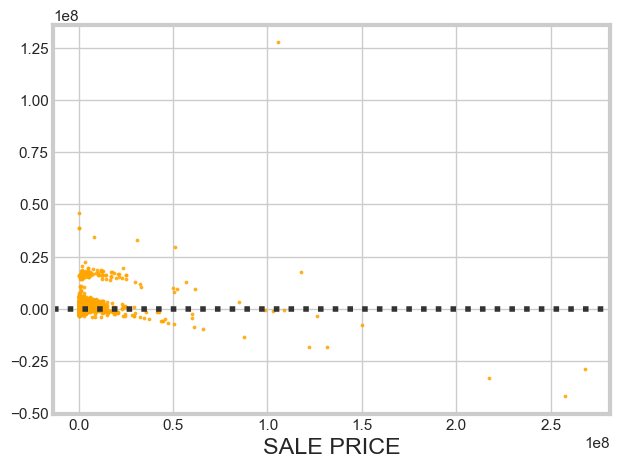

In [462]:
sns.residplot(x=y_test, y=y_pred, color="orange", scatter_kws={"s": 3})